# AM207 - Final project
## Practical Posterior Error Bounds from Variational Objectives

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2019**

**Team members (in alphabetical order):** 

Michael Jetsupphasuk

Thabo Samakhoana

Qiuyang Yin

Chuqiao Yuan

In [1]:
### Import basic libraries
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm
from autograd import grad
from autograd.misc.optimizers import adam
import numpy
import scipy
import autograd.scipy as sp
import pandas as pd
import sklearn as sk
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import seaborn as sns
import pymc3 as pm
from errorbound import Errorbound
from warnings import warn
%matplotlib inline

# 0. Introduction

Many problems in Bayesian statistics, machine learning, and beyond require the ability to compute or sample from a distribution that is often intractable to derive analytically. In Bayesian inference, the target distribution is the posterior. A variety of Markov Chain Monte Carlo (MCMC) methods have been developed to solve this problem. However, MCMC algorithms are not without fault. Often they are computationally intensive, rendering them impractical for empirical researchers that desire to fit many models to large datasets (Blei et al. 2017). Variational inference (VI) and its black-box implementation (BBVI) have been used in recent years for problems where MCMC is not feasible. Despite the widespread use, there are few existing guarantees for how well VI performs in the general case (Blei et al. 2017). A recent paper by Huggins et al. (2019) titled, "Practical posterior error bounds from variational objectives" (from herein referred to as Huggins et al. or "the paper"), provides further guidance by proposing bounds for the errors in important summary statistics between the approximation and the target. 

In particular, they bound errors using Wasserstein distance and then bound the Wasserstein distance using the $\alpha$-divergence. Finally, they bound $\alpha$-divergence by computable quantites. 

In this report, we summarize and comment on the paper by Huggins et al. Section 1 provides background on variational inference, some associated problems, and the previous work to address those problems. In Section 2, we highlight the key details behind the paper. We then explore how the proposed bounds perform in a variety of settings using simulations in Section 3. Then, in Section 4, we reproduce the case study in the paper and comment on it. Finally, we conclude in Section 5 with a summary of the open research questions related to the proposed error bounds. 

# 1. Background

## 1.1 Problem statement

The goal of variational inference (VI) is to find a distribution $\hat{\pi}(\theta)$ that approximates the target posterior distribution $\pi(\theta|Y)$ (following the convention in the paper, we will omit the dependence on the data $Y$ for the remainder of this report) when the posterior is too difficult to sample from with MCMC. In particular, we choose a family of distributions $\mathcal{Q} = \{\xi(\psi|\lambda) | \lambda \in \Lambda\}$ a priori, then find the $\hat{\pi} \equiv \xi(\psi|\lambda^*)$ from this family that minimizes the difference between $\xi$ and $\pi$, where the difference is usually measured by the Kullback-Leibler (KL) divergence. Unlike MCMC methods which sample from the target distribution asymptotically, VI does not generally have any guarantees, asymptotic or otherwise, of matching the posterior. Further, although VI chooses the "best" $\xi \in \mathcal{Q}$, it does not generally tell us how well $\hat{\pi}$ actually approximates the target posterior $\pi$. For instance, the difference between the variational approximation mean and the posterior mean cannot generally be inferred from KL-divergence.

## 1.2 Why is this problem important? 

In variational inference, a divergence metric, such as KL-divergence, is minimized to achieve a distribution that approximates the target posterior. But low KL-divergence does not necessarily imply that the statistical characteristics of the variational approximation are similar to that of the target distribution. To illustrate, we repeat two examples from Huggins et al. that show even when KL-divergence between two distributions is low, the difference in the mean or variance can be arbitrarily large.


### Example: Low KL divergence with poor mean approximation

The following example shows that the posterior mean could be extremely biased (if we regard VI as an estimator) even if KL divergence is small. Let $\hat \pi := Weibull(k/2,1)$ and $\pi := Weibull(k,1)$, then:

$$
KL(\hat \pi | \pi) = -\log(2) + \gamma + \Gamma(3) - 1 < 0.9
$$

where $\gamma$ is the Euler-Mascheroni constant and $\Gamma$ is the gamma function (Bauckhage, 2013). The mean of the approximation and the posterior mean and variance are:

$$
\begin{split}
m_{\hat \pi} &= \Gamma(1 + \frac {2}{k}) \\
m_{\pi} &= \Gamma(1 + \frac {1}{k}) \\
\sigma_{\pi}^2 &= \Gamma(1 + 2/k) - (\Gamma(1+1/k))^2
\end{split}
$$

and therefore,

$$
\lim_{k \searrow 0} \frac{(m_{\hat \pi}  - m_{\pi})^2}{\sigma_{\pi}^2} = \infty
$$

showing that the difference in means approaches infinity as $k$ decreases to 0. 

The above is a copy of Example 3.1 and Appendix A of Huggins et al. Below is an empirical simulation for the example:

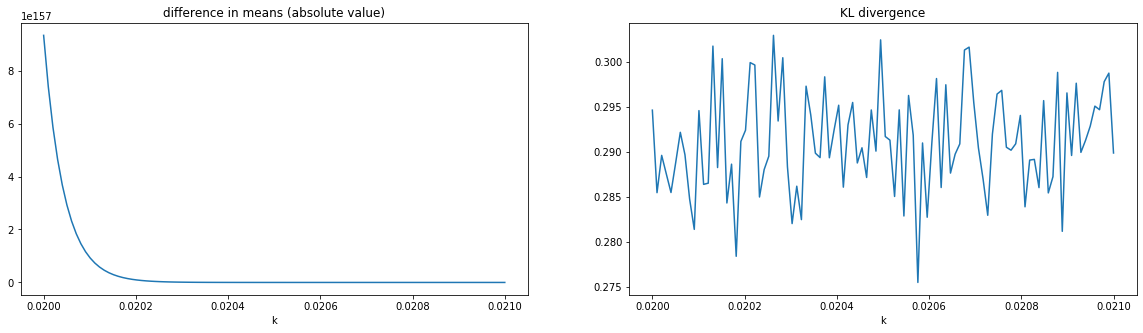

In [2]:
# plot ratio of true variance to approximated variance; plot KL divergence
k_range = np.linspace(0.02, 0.021, 100)

kl_stsh = []
mn_stsh = []
for i in range(len(k_range)):
    k = k_range[i]
    samples = np.random.weibull(k, size=10000)
    kl_stsh.append(-(np.mean(scipy.stats.weibull_min.logpdf(samples, k/2)) - np.mean(scipy.stats.weibull_min.logpdf(samples, k))))
    mn_stsh.append(np.abs(sp.special.gamma(1+1/(k/2)) - sp.special.gamma(1+1/(k))))

fig, ax = plt.subplots(1, 2, figsize = (20, 5))
ax[0].plot(k_range, mn_stsh)
ax[0].set_title('difference in means (absolute value)')
ax[0].set_xlabel('k')

ax[1].plot(k_range, kl_stsh)
ax[1].set_title('KL divergence')
ax[1].set_xlabel('k')
plt.show()

We see that as $k$ decreases to zero, the difference in means of the two distributions blows up, while the KL divergence remains constant around 0.29. This case shows that KL divergence is not informative of the differences in mean.


### Example: Low KL divergence with poor variance approximation

In lieu of repeating the analytical result from the paper, we will show the same example empirically. Let $\pi := T_h$, or the standard t distribution with $h$ degrees of freedom, and $\hat \pi := N(0,1)$. As $h \searrow 2$, $\sigma^2_{\pi}$ approaches infinity while $KL(\hat \pi | \pi)$ is small. Below, we compute $KL(\hat \pi | \pi)$ and show that it is small even when $|\sigma^2_{\hat \pi} - \sigma^2_{\pi}|$ approaches infinity. 

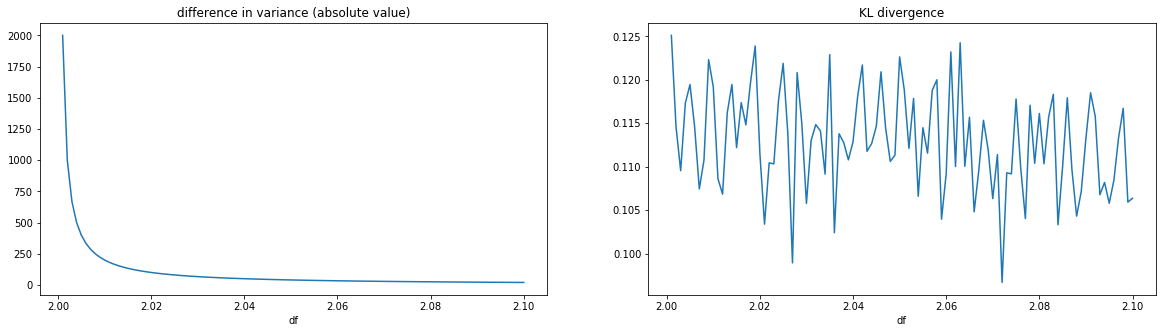

In [3]:
# plot ratio of true variance to approximated variance; plot KL divergence
df_range = np.linspace(2.001, 2.1, 100)
D = 1

kl_stsh = []
var_stsh = []
for i in range(100):
    df = df_range[i]
    log_density = lambda x: np.sum(sp.stats.t.logpdf(x, df=df), axis=1)
    eb = Errorbound(np.array([0]), np.array([1]), propose_family='normal', 
                    log_joint_posterior=log_density, num_samples=10000)
    kl_stsh.append(-eb.elbo())
    var_stsh.append((df/(df-2)) - 1)

fig, ax = plt.subplots(1, 2, figsize = (20, 5))
ax[0].plot(df_range, var_stsh)
ax[0].set_title('difference in variance (absolute value)')
ax[0].set_xlabel('df')

ax[1].plot(df_range, kl_stsh)
ax[1].set_title('KL divergence')
ax[1].set_xlabel('df')
plt.show()

Similar to the previous example, as the degrees of freedom approaches 2, the difference in variance approaches infinity while the KL divergence remains small at less than 0.15. This example shows that KL divergence is not informative of the differences in variance.

## 1.3 Existing work 

Evaluation of the goodness-of-fit of $\hat{\pi}$ is an open area of research. Several papers use Stein discrepancies to bound the Wasserstein distance which can be used to bound the error on summary statistics of the variational approximation and target distribution (Gorham and Mackey, 2015; 2017; Gorham, et al. 2019). However, as Huggins et al. note, these bounds are not generally computationally efficient unless the posterior is of a particular form. 

Yao et al. (2018) propose the usage of $\hat{k}$ in a Pareto-smoothed importance sampling (PSIS) scheme, where $\hat{k}$ is the estimated shape parameter $k$ in a Pareto distribution fitted on the largest importance weights. Yao et al. (2018) argue that smaller values of $\hat{k}$ indicate better $\hat{\pi}$ as smaller values of $\hat{k}$ imply reasonable importance weights, which in turn imply a better fit of the approximation to the target. They argue to use a heuristic guideline of $\hat{k} < 0.7$ to indicate a good fit and a poor approximation otherwise. 

Huggins et al. incorporate PSIS into their proposed workflow. In order to focus our report, we do not implement PSIS and limit discussion to only a high-level. Though $\hat{k}$ proposed by Yao et al. (2018) is a good evaluation tool for posterior approximation, it is a heuristic value in the sense that it does not provide any direct measure on differences in summary statistics between the approximation and target distribution.

## 1.4 Contribution

In contrast to previous work, Huggins et al. propose error bounds for key statistics that are both general and computationally efficient. Provided accurate estimation, these error bounds are also theoretically guaranteed, and the authors argue that these error bounds can serve as a diagnostic tool for how well an approximation fits the target distribution. Additionally, they propose a general workflow for variational inference using these proposed bounds to tune VI. 

# 2. Technical Content

## 2.1 Review of variational inference

In variational inference, we find an approximate distribution $\xi$ from a certain family $\mathcal{Q}$ which minimizes the distance between the approximate distribution and the often intractable target distribution $\pi$. Therefore, two main design decisions are required: (1) Which family of distributions should we choose? (2) How do we measure distance between two distributions? Then, one must fit the model by optimizing the chosen metric to find the optimal $\xi \in \mathcal{Q}$.

**Design decisions**

Researchers often use categorical distributions for the discrete case and normal distributions for the continuous case. Huggins et al. suggest the use of the $t$-distribution in lieu of the normal since the $t$-distribution with small degrees of freedom is more robust at the tails than the normal. Additionally, we often make the **mean-field assumption**, which says that the distributions in the approximation family completely factorize. In the case of choosing the $t$-family, this means that each parameter in $\theta$ is represented by an independent $t$-distribution, or $\xi(\theta)= \prod_{i=1}^I \xi(\theta_i | \lambda_i)$ where $\lambda$ represents the parameters of the $t$-distribution i.e. scale and location (we usually fix degrees of freedom for all $\xi$).

The most common choice of divergence metric is the **Kullback-Leibler (KL) divergence** between approximate distribution $\xi$ and target distribution $\pi$, defined as: 

$$
KL(\xi || \pi) = \int\log\left(\frac{d\xi}{d\pi}\right)d\xi = \mathbb{E}_{\theta \sim \xi(\theta|\lambda)}\left[\log\left( \frac{\xi(\theta | \lambda)}{\pi(\theta)} \right) \right]
$$ 

where $\frac{d\xi}{d\pi}$ denotes the Radon-Nikodym derivative of $\xi$ with respect to $\pi$. For KL divergence, the assumption is that $\pi$ and $\xi$ are defined on the same measurable space and $\pi$ is absolutely continuous with respect to $\xi.$

The purpose of VI is to approximate $\pi(\theta)$, but if $\pi(\theta)$ is not known, then the KL divergence cannot be computed. Therefore, rather than minimizing the KL-divergence, we equivalently maximize the **Evidence Lower BOund (ELBO)**:

$$ \min_{\lambda} KL(\xi || \pi) = \max_{\lambda} ELBO(\lambda) - \log M  $$

where $ELBO(\lambda) = \mathbb{E}_{\theta \sim \xi(\theta|\lambda)}\left[\log\left( \frac{\pi(\theta)'}{\xi(\theta | \lambda)} \right) \right]$, $\pi'$ is the joint distribution, and $M$ is the marginal likelihood. 

This choice of divergence for variational inference is referred to as KLVI. Recently, researchers have proposed using other divergences in VI. One that has gained recent traction is using the $\alpha$-divergence which is defined as: 

$$
D_{\alpha}(\pi |\hat{\pi}) = \frac{1}{\alpha - 1}\int\left(\frac{d\pi}{d\hat{\pi}}\right)^{\alpha - 1}d\pi
$$ 

where $0 < \alpha < 1$ or $\alpha > 1$ (Dieng et al. 2017). For $\alpha$-divergence, the assumptions are the same as that of KL divergence.

Note that the $\alpha$-divergence is a generalization KL divergence where:

$$
D_\alpha(\pi | \epsilon) = \lim_{\alpha \rightarrow 1} D_\alpha(\pi|\epsilon) = KL(\pi | \epsilon)
$$

And it was shown that minimizing $\alpha$-divergence is equivalent to minimizing **Chi Upper BOund (CUBO)** (Dieng et al. 2017)

$$
\text{CUBO}_\alpha(\epsilon) = (1 - \alpha^{-1}) D_{\alpha}(\pi |\epsilon) - \log M 
$$

where $M$ is the marginal likelihood of the target posterior.

According to the transformation above, ELBO is a lower bound for $\log M$. And it was shown that CUBO is an upper bound for $\log M$ (Dieng, et al. 2017). 

$$
\begin{split}
\text{CUBO}_{\alpha}(\epsilon) &= \log\left\{\int\left(\frac{d\pi'}{d\epsilon}\right)^{\alpha}d\epsilon\right\}^{1/\alpha} \\
&\ge \log\left(\int \frac{d\pi'}{d\epsilon}d\epsilon\right) = \log M 
\end{split}
$$

Variational inference where $\alpha$-divergence is minimized is referred to as CHIVI, and although Huggins et al. recommend this implementation over KLVI, we do not implement CHIVI in this report in order to focus our discussion. 

**Computation**

Once the design choices have been made, one must actually compute the maximum (or minimum) of the objective. For both KLVI and CHIVI, the "reparamerization trick" allows for the gradient of the objective to be tractable, leading to a black-box computation (BBVI) (Kingma and Welling 2014; Dieng et al. 2017). Stochastic gradient descent can then be used find the maximum (or minimum) (Hoffman et al. 2013). In this report we use the `adam` function from the `autograd` library in Python to perform this optimization (Kingma and Ba 2015). 

We use the estimator for CUBO described in Dieng et al. (2017):

$$
\hat{L} = \frac{1}{B}\sum^{B}_{b=1}(\frac{p(x,g(\lambda,\epsilon^{(b)}))}{q(g(\lambda, \epsilon^{(b)});\lambda)})^{\alpha}
$$

$$
\hat{CUBO}_{\alpha}(\lambda) = \frac{1}{\alpha}log(\hat{L})
$$

where $g$ is the generative function that allows for the reparameterization trick. For the normal family, this implies that $\epsilon \sim N(0,1)$ and $g(\mu, \sigma) = \mu + \sigma \epsilon$. 

## 2.2 Proposed error bounds

### 2.2.1 High level details

Researchers are often interested in certain point and uncertainty estimates of the posterior distribution, such as the mean $m_{\pi}$, the mean absolute deviation around the mean, $\text{MAD}_{\pi}$, the standard deviation, $\sigma_{\pi}$, and the variance, $\Sigma_{\pi}$. However, VI does not generally guarantee that these summary statistics for $\hat{\pi}$ are close that of the posterior. As shown in Section 1.2, low divergence metrics may still result in large errors in approximation of summary statistics. 

Therefore, Huggins et al. propose bounds for these errors. They proceed by (1) showing that the Wasserstein distance controls the error for these summary statistics; (2) proving that the Wasserstein distance can be bounded by the $\alpha$-divergence; and (3) the $\alpha$-divergence can be bounded by computationally efficient quantities. 

### 2.2.2 Technical details

In this subsection, we repeat and comment on the theorems, propositions, and lemmas that produce the above results. We use the numbering scheme of the paper in order to facilitate easy reference for the reader.

The first result is in regard to the Wasserstein distance which we describe here (Villani 2009; Wasserman n.d.). In the most general form, **Wasserstein distance** is defined for measures on measure spaces where the underlying set is also a metric space. To be precise, let $(\mathcal{X}, d)$ be a metric space. We recall that for $x, y, z \in \mathcal{X},$ this means:
1. $d(x, y) \geq 0$ with equality holding if and only if $x = y,$
2. $d(x,y) = d(y, x),$ and 
3. $d(x, z) \leq d(x, y) + d(y, z).$

Let $p_1$ and $p_2$ be the maps $(x, y) \mapsto x$ and $(x, y) \mapsto y$, respectively, defined on the product space $\mathcal{X} \times \mathcal{X}.$ The $p$-th Wasserstein distance between two (Borel) measures $\eta$ and $\nu$ on $\mathcal{X}$ is $$\inf\limits_{\gamma \in \Gamma(\eta, \nu)}\left(\int_{\mathcal{X}}d(x, y)^p d\gamma(x,y)\right)^{1/p}$$ 

where $\Gamma(\eta, \nu),$ called the set of couplings of $\eta$ and $\nu,$ is given by 

$$\Gamma(\eta, \nu) = \left\{\gamma\; : \; \eta = p_{1 \#\gamma}, \nu = p_{2 \#\gamma}\right\}.$$ 

Here $p_{i \#\gamma}$ is the push forward measure under the coordinate projection $p_i,$ $i \in \{1, 2\};$ that is, for any Borel set $A \in \mathcal{X},$ $p_{i \#\gamma}(A) = \gamma\left(\left\{(x, y) \in \mathcal{X} \times \mathcal{X} \; : \;p_i(x, y) \in A\right\}\right).$

In the paper $(\mathcal{X}, d)$ is $\mathbb{R}^n$ with the $l_2$-norm.

The important point to take away is that unlike KL- or $\alpha$-divergence, the Wasserstein distance takes metric defined on the underlying space into consideration, so it is natural to derive error bounds on summary statistics from the Wasserstein distance (but it is infeasible to estimate or use as a variational objective).

The $p$-Wasserstein distance, $W_p$, can be shown in the following theorem to control errors for the desired summary statistics.

---------------------
**Theorem 3.1**. If $W_1 (\hat \pi, \pi) \le \epsilon$, then

$$
||m_{\hat \pi} - m_{\pi}||_2 \le \epsilon \quad and \quad \max_i | \text{MAD}_{\hat \pi, i} - \text{MAD}_{\pi, i} | \le 2\epsilon. 
$$

If $W_2(\hat \pi, \pi) \le \epsilon$, then for $C := \sqrt {\min \{ ||\Sigma_{\hat \pi}||_2, ||\Sigma_{\pi}||\}}$:


$$
\max_i | \sigma_{\hat\pi} - \sigma_{\pi, i}| \le 2 \epsilon \quad and \quad  || \Sigma_{\hat \pi} - \Sigma_{\pi}|| < 3 C \epsilon + 6 \epsilon^2
$$

---------------------------

Huggins et al. also remark that $W_p$ increases as $p$ increases (from Jensen's inequality), which implies that $W_1 \leq W_2 \leq \epsilon$ so $W_2$ can also control the mean and MAD errors. This is an important remark as we will see that often in practice the computable bound on $W_2$ is actually smaller than the computable bound on $W_1$ (note that there is no theoretical inconsistency as it is possible for a bound on $W_2$ to be tighter than a bound on $W_1$).

Next, we note that the following results by Huggins et al. provide bounds for when $\xi$ is $p$-polynomially integrable and when $\xi$ is $p$-exponentially integrable. However, in VI we usually choose $\xi$ to be from a $t$ or normal family, distributions which are $p$-polynomially integrable but not $p$-exponentially integrable. Therefore, we omit discussion of the $p$-exponentially integrable results for the remainder of this report.

---------------------
**Proposition 4.1**. If $\pi$ is absolutely continuous with respect to $\hat{\pi}$, then

$$
W_p(\hat \pi, \pi) \leq C^{PI}_{2p}(\hat{\pi})\left[\exp\{D_2(\pi | \hat \pi) - 1\}\right]^{1/2p}
$$

---------------------------

where 

$$
C^{PI}_{p}(\xi) = 2\inf_{\theta_0 \in \mathcal{X}}\left\{\int_{\mathcal{X}}||\theta - \theta_0||_2^p\xi(d\theta)\right\}^{1/p}
$$ 

This proposition connects Wasserstein distance with $D_2$ divergence, which will be bounded by CUBO and ELBO in the following lemma. 

---------------------
**Lemma 4.2** For any distribution $\eta$ such that $\pi$ is absolutely continuous with respect to $\eta$ ($\pi \ll \eta$),

$$KL(\pi | \hat{\pi}) \leq D_{\alpha}(\pi | \hat{\pi}) \leq H_{\alpha}(\hat{\pi}, \eta)$$

---------------------------

where 

$$ H_{\alpha}(\hat{\pi}, \eta) = \frac{\alpha}{\alpha - 1}\left\{\text{CUBO}_{\alpha}(\hat{\pi}) - \text{ELBO}(\eta)\right\} $$

Finally, Huggins et al. combine Proposition 4.1 and Lemma 4.2 to give computable bounds on Wasserstein distance.

---------------------
**Theorem 4.3** For any $p \geq 1$ and any distribution $\eta $, if $\pi$ is absolutely continuous with respect to $\hat{\pi}$, then

$$  W_p(\hat \pi, \pi) \leq C^{PI}_{2p}(\hat{\pi})\left[\exp\{H_2(\hat{\pi}, \eta) - 1\}\right]^{1/2p} $$

---------------------------

Since $C_{2p}$ and $H_2$ are computable, Huggins et al. achieve their goal of bounding error for common summary statistics.

We note that though the restrictions on $\eta$ are loose (since we only need $\pi \ll \eta$), in practice we will generally choose $\eta$ to be $\hat \pi$. We prefer tighter bounds so we would like to minimize $H_{2}$ and without specific information on $\hat{\pi}$, a reasonable default is to argue that the difference between $CUBO$ and $ELBO$ is small when they are respect to the same distribution. One possible area of future research may be to rigorously optimize to find $\eta$ that minimizes $H_{2}$. 

### 2.2.3 Highlighted parts of the proof

**Proof of Theorem 3.1**. We summarize some of the key details of the proof of Theorem 3.1 (in the paper these are contained in *D.1. Proof of Theorem 3.1* and *Proof of Theorem D.1*). 

The 1-Wasserstein distance which can be expressed as (Villani 2009): 

$$ 
W_1(\xi, \pi) = \sup_{\phi: ||\phi||_L \leq 1} |\xi(\phi) - \eta(\phi)|
$$ 

and by Jensen's inequality, for $p \geq 1$, $W_1 \leq W_p$ and an upper bound on $W_p$ is also a bound on $W_1$ so $W_1 \leq W_p \leq \epsilon$. Now, let $\phi$ be any $L$-Lipschitz function and let $||\phi||_L \leq L$. Then, since $||\frac{\phi}{L}||_L \leq 1$, then the condition of the supremum of $W_1$ is fulfilled and:

$$
\begin{aligned}
|\xi(\frac{\phi}{L}) - \eta(\frac{\phi}{L})| &= \frac{1}{L}|\xi(\phi) - \eta(\phi)| \\
&\leq \sup_{\phi: ||\phi||_L \leq 1} |\xi(\phi) - \eta(\phi)| \\
&\leq \epsilon
\end{aligned}
$$

Therefore, $|\xi(\phi) - \eta(\phi)| \leq L\epsilon$. This leads to the key result:

$$ 
|\mathrm{E}(\phi(\mathcal{V}) - \phi(\hat{\mathcal{V}}))| \leq \epsilon ||\phi||_L 
$$

where $\mathcal{V} \sim \xi$ and $\hat{\mathcal{V}} \sim \eta$. If $W_1 \leq \epsilon$ and we let $\phi(x) = x$ (which is a 1-Lipschitz function), then $|\mathrm{E}(\mathcal{V}) - \mathrm{E}(\hat{\mathcal{V}})| \leq \epsilon$ and we have successfully bounded the absolute difference in means with the Wasserstein distance using the fact that $W_1 \leq \epsilon$. We highlight the proof on the mean error bound in particular as we show later that it may be the most important bound in practice. 

**Proof of Theorem 4.3**. Next, we show how Huggins et al. bound the Wasserstein distance by computable quantities. First, take **Proposition 4.1** as given (for more details see Section 5 of the paper and Appendix C).

Then, $D_2$ can be expressed as:

$$ D_2(\pi | \hat{\pi}) = 2\left[ CUBO_2(\hat{\pi}) - \log M \right] $$

where $M$ is the marginal likelihood. Next, if we represent $ELBO$ as

$$ ELBO(\eta) := \log M - KL(\eta | \pi) $$

and observe that KL-divergence is also positive, then $ELBO(\eta) \leq \log M$. Combining these results gives:

\begin{aligned}
D_2(\pi | \hat{\pi}) &= 2\left[ CUBO_2(\hat{\pi}) - \log M \right] \\
&\leq 2\left[ CUBO_2(\hat{\pi}) - ELBO(\eta) \right] \\
&= H_2(\hat{\pi}, \pi)
\end{aligned}


and **Theorem 4.3** is proved and the Wasserstein distance can be computed using CUBO and ELBO.

## 2.3 Workflow

Huggins et al. also propose a workflow based on their proposed error bounds. The full details are at the end of Section 4 in their paper. We do not discuss the workflow extensively here as it involves methods that we do not implement in this report, specifically the $\hat k$ statistic from Yao et al. (2018), PSIS, and CHIVI. 

The spirit of their proposed workflow is to use the error bounds as a guide for how well VI is performing. If the error bounds are small, the practitioner can be confident that the variational summary statistics are close to the posterior summary statistics, and no further work is required. However, if the bounds are large, then Huggins et al. argue for refinement of the model by either choosing a better variational family $\mathcal{Q}$ or reparameterizing the model.

Huggins et al. exercise their workflow in the "Eight Schools" example, which we partially replicate in Section 4 and comment on.

## 2.4 Algorithm

The computation of these bounds is summarized in **Algorithm 1** in Huggins et al. We summarize the algorithm further here:

1. Compute ELBO and CUBO using Monte Carlo estimation.
2. Compute 2-divergence bound based on approximated ELBO and approximated CUBO.
3. Compute 2-Wasserstein distance bound based on 2-divergence bound and moment constants.
4. Compute error bounds for differences in summary statistics between approximate distribution and target posterior distribution.

We implement the algorithm below. Also note that Huggins et al. have published this algorithm at https://github.com/jhuggins/viabel. Our code is useful for the pedagogical cases presented in this report but the code published by Huggins et al. is more general and is recommeneded over the code here.

In [4]:
class Errorbound():
    def __init__(self, mean, std, propose_family, log_joint_posterior, num_samples, t_dist_df=None):
        """
        Initiate a class to calculate ELBO, CUBO, error bounds for divergence metric and distance metric 
        
        Parameters
        ---------
        mean (array): array of mean of proposed distribution
        std (array): array of std of proposed distribution
        propose_family (str): "normal" or "t", indicate family of the proposed distribution
        t_dist_df (int): degree of freedom of proposed t distribution
        log_joint_posterior (density function): log density function of target posterior
        num_samples (int): number of samples
        
        Returns
        ------
        a class for error bound calculation
        """
        self.mean = mean
        self.std = std
        assert len(self.mean) == len(self.std) ## dimension of mean and standard deviation should be the same
        self.family = propose_family
        self.t_dist_df = t_dist_df
        self.log_joint_posterior = log_joint_posterior
        self.num_samples = num_samples
        
        # draw samples
        rs = np.random.RandomState()
        D = len(self.mean)
    
        if self.family=='normal':
            self.samples = rs.randn(self.num_samples, D) * self.std + self.mean
        if self.family=='t':
            assert self.t_dist_df is not None
            self.samples = rs.standard_t(df=self.t_dist_df, size=(self.num_samples, D)) * self.std + self.mean

    def C_2p(self):
        """
        Compute Cp for proposed distribution
        """
        p = 2
        samples_mean = self.samples.mean(axis=0, keepdims=True)
        samples_centered = self.samples - samples_mean
        samples_l2norm = np.sqrt(np.sum(samples_centered**2, axis=1))
        return 2*(np.mean(samples_l2norm**(2*p))**(1/(2*p)))
    
    def elbo(self):
        """
        Compute ELBO for proposed t distribution and the target posterior distribution
        
        Returns
        ------
        elbo lower bound of proposed t distribution and target posterior       
        """
        def gaussian_entropy(log_std):
            D = len(log_std)
            return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)
        
        def t_entropy(df, scale=None):
            ''' Taken from https://math.stackexchange.com/questions/2272184/differential-entropy-of-the-multivariate-student-t-distribution'''
            standard_entropy = ((df+1)/2)*(sp.special.digamma((df+1)/2) - sp.special.digamma(df/2)) + np.log(np.sqrt(df) * sp.special.beta(df/2, 1/2))
            if scale is None:
                return standard_entropy
            D = len(scale)
            return standard_entropy*D + np.log(scale).sum()

        if self.family == 'normal':
            lower_bound = np.mean(self.log_joint_posterior(self.samples)) + gaussian_entropy(np.log(self.std))
        elif self.family == 't':
            assert self.t_dist_df is not None
            lower_bound = np.mean(self.log_joint_posterior(self.samples)) + t_entropy(df=self.t_dist_df, scale=self.std) 
        return lower_bound
            
    def cubo_2(self):
        """
        Compute CUBO when alpha is 2 for proposed t distribution and the target posterior distribution
    
        Returns
        ------
        Chi upper bound of proposed t distribution and target posterior    
        """        
        joint_posterior = lambda x: np.exp(self.log_joint_posterior(x))
        if self.family=='normal':
            log_inner = self.log_joint_posterior(self.samples) - sp.stats.multivariate_normal.logpdf(self.samples, self.mean, np.diag(self.std**2))
        elif self.family=='t':
            assert self.t_dist_df is not None
            log_inner = self.log_joint_posterior(self.samples) - np.sum(sp.stats.t.logpdf(self.samples, df=self.t_dist_df, loc=self.mean, scale=self.std), axis=1)
    
        rescaled_inner = np.exp(log_inner - np.max(log_inner))**2
        upper_bound = 0.5*np.log(np.mean(rescaled_inner)) + np.max(log_inner)
        return upper_bound      
    
    def divergence_bound(self):
        """
        Compute error bound for divergence metrics when alpha is 2
    
        Returns
        ------
        Error bound for KL divergence and alpha divergence metrics 
        """
        return 2*(self.cubo_2() - self.elbo())
    
    def distance_bound(self):
        """
        Compute error bound for Wasserstein distance metric when p is 2
        
        Returns
        ------
        Error bound for Wasserstein distance metric 
        """        
        p=2
        return self.C_2p()*(np.exp(self.divergence_bound())-1)**(1/(2*p))
    
    def get_bounds(self, verbose=True):
        """
        Print CUBO, ELBO, error bound for divergence metrics, error bound for W2_bound if verbose is true
        Get error boundaries for different summary statistics
        
        Parameters
        ----------
        verbose(bool): Print intermidiate process or not
        
        Returns
        ------
        Error bounds for all kinds of summary statistics
        """
        elbo = self.elbo()
        cubo = self.cubo_2()
        Cp = self.C_2p()
        div_bound = self.divergence_bound()
        dis_bound = self.distance_bound()
        if verbose:
            print('cubo:', cubo)
            print('elbo:', elbo)
            print('div_bound:', div_bound)
            print('C_2p:', Cp)
            print('W2_bound:', dis_bound)
        if self.samples.shape[1] == 1:
            min_std = self.std[0]
        else:
            min_std = np.sqrt(np.cov(self.samples.flatten()))
        all_bounds = {'mean bound': dis_bound,
                 'std bound': 0.5*(np.sqrt(2) + np.sqrt(6))*dis_bound,
                 'variance bound': 2*np.sqrt(2)*min_std*dis_bound + (1+3*np.sqrt(2))*dis_bound**2}
        return all_bounds

# 3. Evaluation

So far our discussion has been entirely theoretical -- Huggins et al. rigourously prove theorems that guarantee to bound the errors of interest. Now we will discuss the practical questions that naturally arise: Are the assumptions needed to compute the bounds realistic? Are the bounds tight or loose? How do they scale as the differences between the distributions increase? How do they scale with dimensionality? Are the computable quantities actually easy to estimate accurately? We will analyze each of these questions in turn. 

## 3.1 Assumptions required

One of the remarkable aspects of Huggins et al. is the lack of strong assumptions needed for the bounds to be valid. We noted these above in section 2 but repeat here for emphasis. In order to have non-infinite bounds, the constants $C_p^{PI}(\xi)$ or $C_p^{EI}(\xi)$ (omitted above) must be finite, in which case $\xi$ is said to be $p$-polynomially integrable or $p$-exponentially integrable, respectively. Since $\xi$ is in respect to the variational family $\mathcal{Q}$ that the user specifies, it is easy to meet this condition. Importantly, the common $t$ and normal variational families are polynomially integrable. 

Second, the target must be absolutely continuous with respect to the approximation, a condition necessary to compute the ELBO or CUBO, meaning that usual methods of VI will already necessarily satisfy this condition. 

## 3.2 Simulations

### 3.2.1 A simple successful example

We begin with a simple pedagogical example. Consider the following two distributions: 
$$
\hat{\pi} \sim \text{N}(0,1)
$$

$$
\pi \sim \text{N}(0,4)
$$

where $\pi = \pi'$ (the posterior is equal to the joint and the marginal likelihood, $M$, is 1). Then, clearly:

$$ | \sigma_{\pi} - \sigma_{\hat \pi} | = 1 \hspace{20pt} \text{and} \hspace{20pt} | \sigma_{\pi}^2 - \sigma_{\hat \pi}^2 | = 3 $$

The key idea motivating the paper is that KL divergence does not give much interpretable guidance on how well summary statistics align. For example, we can compute the KL divergence which is just the negative of the ELBO in this case (because $M=1$). 

In [5]:
log_density = lambda x: sp.stats.norm.logpdf(x, 0, 2).reshape((-1,))
eb = Errorbound(np.array([0]), np.array([1]), 'normal', log_density, 10000)
print("KL divergence between N(0,1) and N(0,4) is {}".format(-eb.elbo()))

KL divergence between N(0,1) and N(0,4) is 0.31744564250632035


A KL divergence of 0.32 is difficult to interpret as there is no comparison point. What do the proposed bounds say?

In [6]:
log_density = lambda x: sp.stats.norm.logpdf(x, 0, 2).reshape((-1,))
eb = Errorbound(mean=np.array([0]), std=np.array([1]), propose_family='normal', 
                log_joint_posterior=log_density, num_samples=10000)
dic = eb.get_bounds(verbose=False)
print("Error bound for mean difference is {}".format(dic['mean bound']))
print("Error bound for std difference is {}".format(dic['std bound']))
print("Error bound for variance difference is {}".format(dic['variance bound']))

Error bound for mean difference is 9.649186148292825
Error bound for mean difference is 16.07219680081235
Error bound for std difference is 31.049099950210376
Error bound for variance difference is 1399.7144402468398


We see that error bounds given by the implemented algorithm are indeed higher than the true values and the interpretation is straightforward - the true difference in means is less than about 5. And the computation is not expensive as only 10000 data points are sampled from the approximate distribution.

We can do the same when the theoretical difference is larger as below. The KL-divergence is six times as large yet that says little about the relevant summary statistics. The error bounds, on the other hand, are interpretable and indeed higher than true values. 

$$
\hat{\pi} \sim \text{N}(0,1)
$$

$$
\pi \sim \text{N}(0,100)
$$

$$ | \sigma_{\pi} - \sigma_{\hat \pi} | = 9 \hspace{20pt} \text{and} \hspace{20pt} | \sigma_{\pi}^2 - \sigma_{\hat \pi}^2 | = 99 $$

In [7]:
log_density = lambda x: sp.stats.norm.logpdf(x, 0, 10).reshape((-1,))
eb = Errorbound(np.array([0]), np.array([1]), 'normal', log_density, 10000)
dic = eb.get_bounds(verbose=False)

print("KL divergence between N(0,1) and N(0,100) is {}".format(-eb.elbo()))
print("Error bound for mean difference is {}".format(dic['mean bound']))
print("Error bound for std difference is {}".format(dic['std bound']))
print("Error bound for variance difference is {}".format(dic['variance bound']))

KL divergence between N(0,1) and N(0,100) is 1.8077040468005774
Error bound for mean difference is 9.226268535688424
Error bound for std difference is 17.823782117799347
Error bound for variance difference is 472.37053704438483


### 3.2.2 Pathological example revisited

In Section 1.2 above we repeated the pathological example in the paper where Huggins et al. showed that when $\hat \pi := N(0,1)$ and $\pi := \text{Standard-t}(df = h)$, then as $h \searrow 2$, KL divergence remains low while the difference in variance approaches infinity. Here, we examine how the proposed error bounds perform. The graph on the left is the same as before and the graph on the right shows five series of the variance error bounds for 100 computations with varying degrees of freedom, $h$.

We would like for the error bound to scale with the difference in variance and explode towards infinity at the same time. Unfortunately, this is not the case here. The bounds are not at all monotonic with $h$ as we would like, and although the bounds do appropriately explode at times, the pattern is neither reasonable nor predictable. Additionally, the five computations hints at instability as the lines do not overlap sensibly.

However, interestingly an analytical analysis shows that the bounds should indeed approach infinity. We leave the details for the appendix, but the essential idea is that $\alpha$-divergence, $D_{\alpha}(\pi | \hat \pi)$, is an upper bound for KL-divergence, $KL(\pi | \hat \pi)$ (note that in the previous demonstration we calculated $KL(\hat \pi | \pi)$), and $KL(\pi | \hat \pi)$ can be shown to approach infinity. Therefore, since the error bounds include a bound for $\alpha$-divergence, they should approach infinity. 

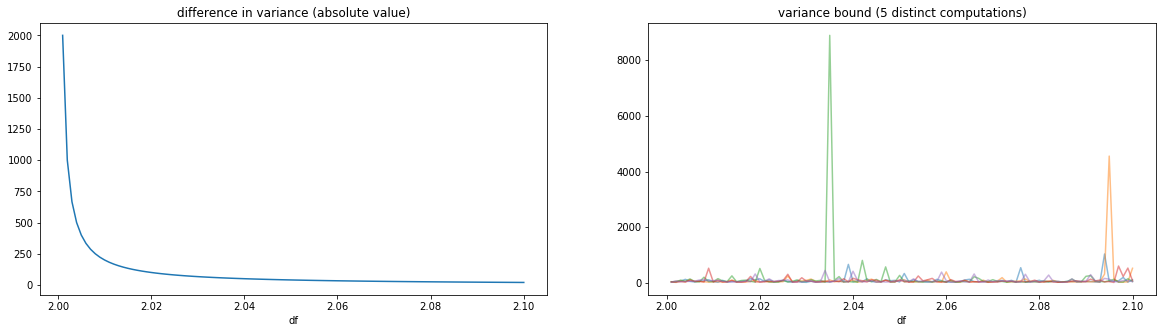

In [8]:
# plot ratio of true variance to approximated variance; plot KL divergence
df_range = np.linspace(2.001, 2.1, 100)

bds_stsh = []
var_stsh = []
for i in range(100):
    df = df_range[i]
    log_density = lambda x: np.sum(sp.stats.t.logpdf(x, df=df), axis=1)
    bds2_stsh = []
    for _ in range(5):
        eb = Errorbound(np.array([0]), np.array([1]), propose_family='normal', 
                        log_joint_posterior=log_density, num_samples=5000)
        bds2_stsh.append(eb.get_bounds(verbose=False)['variance bound'])
    bds_stsh.append(bds2_stsh)
    var_stsh.append((df/(df-2)) - 1)
    
bds_stsh = np.array(bds_stsh).T

fig, ax = plt.subplots(1, 2, figsize = (20, 5))
ax[0].plot(df_range, var_stsh)
ax[0].set_title('difference in variance (absolute value)')
ax[0].set_xlabel('df')

for j in range(5):
    ax[1].plot(df_range, bds_stsh[j], alpha=0.5)
ax[1].set_title('variance bound (5 distinct computations)')
ax[1].set_xlabel('df')
plt.show()

Below we break out the components of the variance bounds for a fixed degrees of freedom $h=2.001$ and 100 computations. Note that the constant $C_p^{PI}$ is constant here (so it is omitted) because it is computed in respect to $\hat \pi$ which is the same in all the experiments. We obseve that the variance bounds explode some of the times but the variation in our variation bounds is still troubling. 

Why does this happen? We proceed by investigating the effects of sample size and difference in distributions on the error bounds.

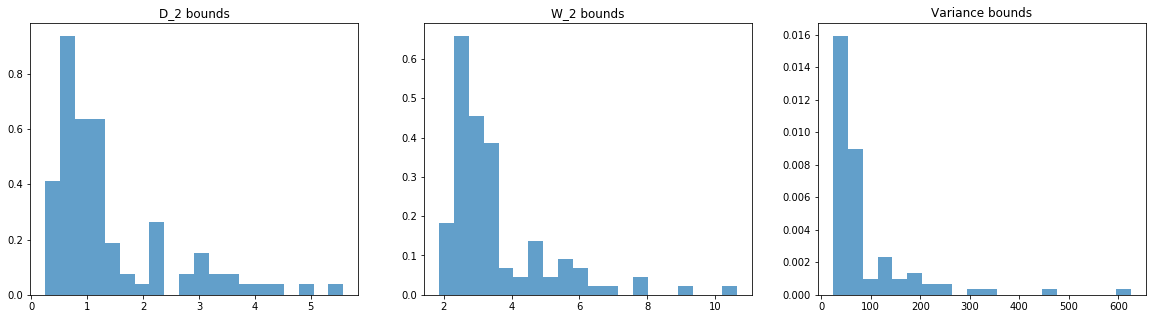

In [9]:
# repeat experiments for same df
df = 2.001
log_density = lambda x: np.sum(sp.stats.t.logpdf(x, df=df), axis=1)
d2_bounds = []
w2_bounds = []
var_bounds = []

# get the error bounds
for _ in range(100):
    eb = Errorbound(np.array([0]), np.array([1]), propose_family='normal', 
                    log_joint_posterior=log_density, num_samples=5000)
    d2_bounds.append(eb.divergence_bound())
    w2_bounds.append(eb.distance_bound())
    var_bounds.append(eb.get_bounds(verbose=False)['variance bound'])

# plot it
fig, ax = plt.subplots(1, 3, figsize = (20, 5))
ax[0].hist(d2_bounds, alpha=0.7, bins=20, density=True)
ax[0].set_title('D_2 bounds')
ax[1].hist(w2_bounds, alpha=0.7, bins=20, density=True)
ax[1].set_title('W_2 bounds')
ax[2].hist(var_bounds, alpha=0.7, bins=20, density=True)
ax[2].set_title('Variance bounds')
plt.show()

### 3.2.3 Effect of sample size on error bounds

We now return to the simple pedagogical example:
$$
\hat{\pi} \sim \text{N}(0,1)
$$

$$
\pi \sim \text{N}(0,4)
$$

$$
\text{true std difference} = 1
$$

and try different sample sizes (from $10^{2}$ to $10^{6}$) when computing the bounds. (Previously we fixed the number of sample sizes to be 5000 or 10000.) We would like to examine the sensitivity to the number of samples since we observed poor estimates in the previous example. Below we compute the error bound 15 times for each sample size and take the median, and plot the results against sample size (on the log scale). 

This example appears to require quite a large sample size in order to achieve accurate bounds. Interestingly, using too few samples seems to cause an under-estimation of the bounds.

In [10]:
def plot_samples(num_samples, ans, ax, label, baseline):
    ax.plot(num_samples, ans, label = 'estimated {} bound'.format(label))
    ax.axhline(y = baseline, color = 'red', label = 'theoretical {} difference'.format(label))
    ax.set_xscale('log')
    ax.set_xlabel('number of samples')
    ax.set_ylabel('median of bound')
    ax.set_title('Effect of number of samples on {} bound'.format(label))
    return ax

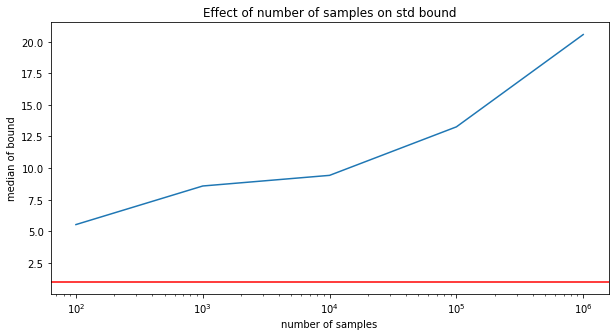

In [11]:
log_density = lambda x: sp.stats.norm.logpdf(x, 0, 2).reshape((-1,))
num_trials = 5
num_samples = 10**(np.linspace(2, num_trials+1, num_trials))

ans = []
times = 15
for n in range(num_trials):
    temp = []
    for _ in range(times):
        eb = Errorbound(mean=np.array([0]), std=np.array([1]), propose_family='normal', 
                        log_joint_posterior=log_density, num_samples = np.int(num_samples[n]))
        dic = eb.get_bounds(verbose=False)
        temp.append(dic['std bound'])
    ans.append(np.median(temp))

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax = plot_samples(num_samples, ans, ax, 'std', 1)
ax.legend(loc='best')
plt.show()

We now show a similarly simple example where this time the variances are fixed but the means are different:

$$
\hat{\pi} \sim \text{N}(0,1)
$$

$$
\pi \sim \text{N}(3, 1)
$$

$$
\text{true mean difference} = 3
$$

Again, the results are similar. Low sample sizes tend to underestimate the bounds. 

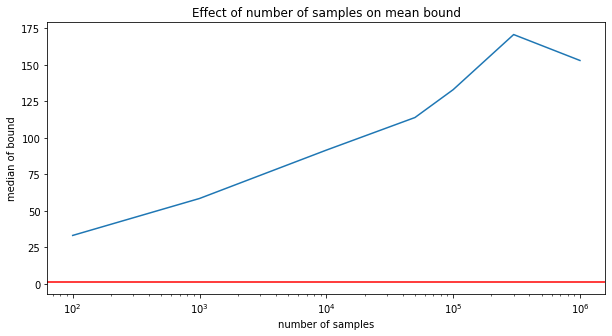

In [12]:
num_samples = [100, 1000, 10000, 50000, 100000, 300000, 1000000]

ans = []
times = 15
for n in num_samples:
    temp = []
    for _ in range(times):
        log_density = lambda x: sp.stats.norm.logpdf(x, 3, 1).reshape((-1,))
        eb = Errorbound(mean=np.array([0]), std=np.array([1]), propose_family='normal', 
                        log_joint_posterior=log_density, num_samples = n)
        dic = eb.get_bounds(verbose=False)
        temp.append(dic['mean bound'])
    ans.append(np.median(temp))

fig, ax = plt.subplots(1, 1, figsize = (10,5))
ax = plot_samples(num_samples, ans, ax, 'mean', 1.5)
ax.legend(loc='best')
plt.show()

We experiment with sample size once more, but this time we explore a situation where the difference between variance of proposal distribution and target distribution is extremely large.

In the following example:
$$
\hat{\pi} \sim \text{N}(0,1)
$$

$$
\pi \sim \text{N}(0,2500)
$$

$$
\text{true std difference} = 49
$$

This example is likely unrealistic in practice but it shows that when estimation is extremely poor, then the error bounds can be so underestimated that they are in fact below the true theoretical error. We can view this example as an edge case where the proposed error bounds fail for reasonable sample sizes. 

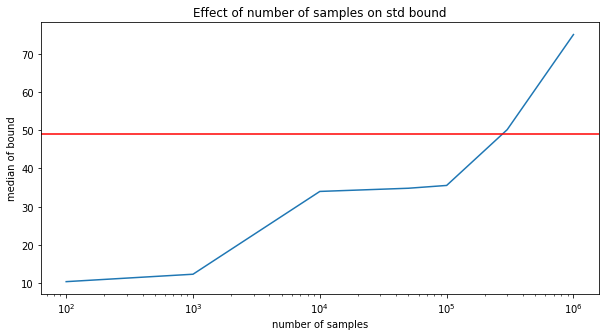

In [13]:
num_samples = [100, 1000, 10000, 50000, 100000, 300000, 1000000]

ans = []
times = 15
for n in num_samples:
    temp = []
    for _ in range(times):
        log_density = lambda x: sp.stats.norm.logpdf(x, 0, 50).reshape((-1,))
        eb = Errorbound(mean=np.array([0]), std=np.array([1]), propose_family='normal', 
                        log_joint_posterior=log_density, num_samples = n)
        dic = eb.get_bounds(verbose=False)
        temp.append(dic['std bound'])
    ans.append(np.median(temp))

fig, ax = plt.subplots(1, 1, figsize = (10,5))
ax = plot_samples(num_samples, ans, ax, 'std', 49)
ax.legend(loc='best')
plt.show()

### 3.2.4 Effect of distance between approximate distribution and target posterior distribution

A reasonable follow-up question to the previous example is: at what point are two distributions so far apart that estimation becomes difficult? In the following experiment, we fix the sample size to be $10^6$, vary the standard deviation (again staying with our normal-normal framework), and examine the bounds. 

$$
\hat{\pi} \sim \text{N}(0,1)
$$

$$
\pi \sim \text{N}(0,\sigma^{2}) (\sigma = \text{1.1, 1.25, 1.5, 2, 5, 10, 15, 30, 50, 100})
$$

$$
\text{true std difference} = \sigma-1
$$

In this example, the error bounds become truly degenerate when the true difference in standard deviation is about 50. 

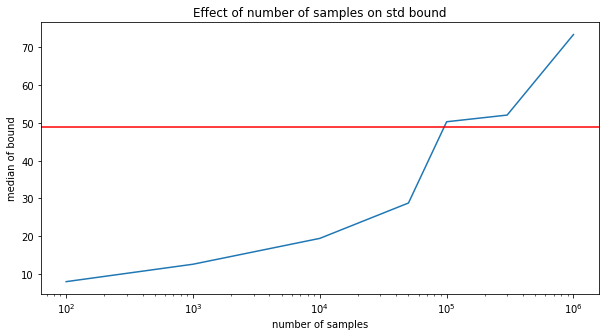

In [14]:
num_samples = [100, 1000, 10000, 50000, 100000, 300000, 1000000]

ans = []
times = 15
for n in num_samples:
    temp = []
    for _ in range(times):
        log_density = lambda x: sp.stats.norm.logpdf(x, 0, 50).reshape((-1,))
        eb = Errorbound(mean=np.array([0]), std=np.array([1]), propose_family='normal', 
                        log_joint_posterior=log_density, num_samples = n)
        dic = eb.get_bounds(verbose=False)
        temp.append(dic['std bound'])
    ans.append(np.median(temp))

fig, ax = plt.subplots(1, 1, figsize = (10,5))
ax = plot_samples(num_samples, ans, ax, 'std', 49)
plt.show()

In [15]:
def plot_samples2(paras, theor, ans, ax, label = 'std', xlabel = 'mu'):
    ax.plot(paras, ans, label = 'estimated {} bound'.format(label))
    ax.plot(paras, theor, color = 'red', label = 'true {} difference'.format(label))
    ax.set_xlabel(xlabel)
    ax.set_ylabel('median of bound')
    ax.set_title('Effect of {} on bound {}'.format(xlabel, label))
    return ax

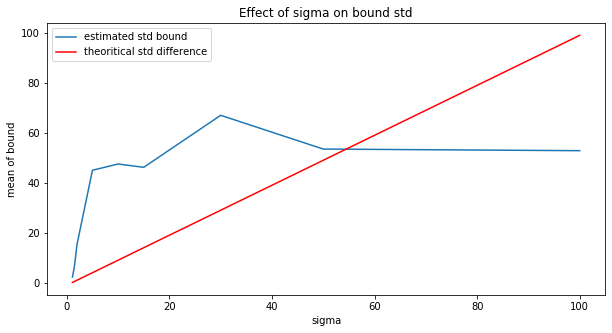

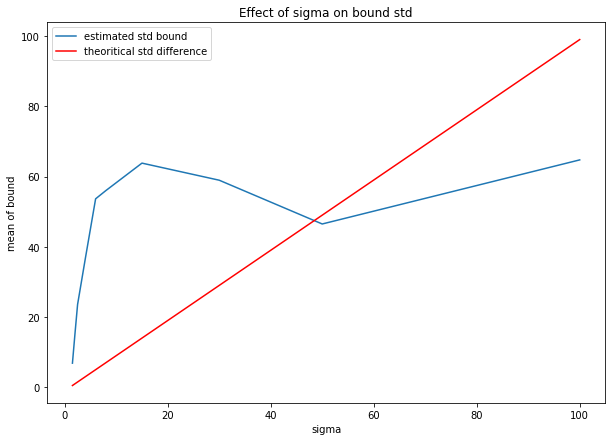

In [16]:
sigmas = [1.1, 1.25, 1.5, 2, 5, 10, 15, 30, 50, 100]

ans = []
times = 50
for sigma in sigmas:
    temp = []
    for _ in range(times):
        log_density = lambda x: sp.stats.norm.logpdf(x, 0, sigma).reshape((-1,))
        eb = Errorbound(mean=np.array([0]), std=np.array([1]), propose_family='normal', 
                        log_joint_posterior=log_density, num_samples = 100000)
        dic = eb.get_bounds(verbose=False)
        temp.append(dic['std bound'])
    ans.append(np.median(temp))

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax = plot_samples2(sigmas, list(map(lambda x: x-1, sigmas)), ans, ax, label = 'std', xlabel = 'sigma')
ax.legend(loc='best')
plt.show()

### 3.2.5 CUBO estimation

We further explore the reasons behind the phenomena mentioned in Section 3.2.3 and 3.2.4.

The $W_2$ bound forms the basis for the mean and covariance bounds that we computed above. Recall from **Theorem 4.3** in the paper that the bound is computed as:

$$W_2\ \text{bound} = C^{PI}_{2p}(\hat{\pi})\left[\exp\{H_2(\hat{\pi}, \eta) - 1\}\right]^{1/2p} $$

In all of the previous experiments, we set $\hat \pi$ to be the standard normal distribution so the moment constant $C^{PI}_{2p}$ is the same throughout. However, $H_2$ varies as it takes the form (**Proposition 4.1** in the paper):

$$ H_{\alpha}(\hat{\pi}, \eta) = \frac{\alpha}{\alpha - 1}\left\{\text{CUBO}_{\alpha}(\hat{\pi}) - \text{ELBO}(\eta)\right\} $$

and we choose $\eta$ to be $\hat \pi$. Both CUBO and ELBO are also functions of $\pi$ so estimation of CUBO and ELBO depends on the relationship between $\pi$ and $\hat \pi$. We find that estimation of CUBO can be especially difficult and when the two distributions are far apart, standard Monte Carlo estimates of CUBO become degenerate.

Below, we calculate the theoretical CUBO value for two univariate normal distributions with equal variance, and we vary the mean in one of the distributions (as described below). As we vary the mean $\mu$, we also calculate the unbiased Monte Carlo estimate of CUBO described in Dieng et al. (2017) and graph both for different sample sizes.

$$
\hat{\pi} \sim \text{N}(\mu,1)
$$

$$
\pi \sim \text{N}(0,1)
$$

$$
\text{theoretical CUBO} = 0.5 \log(\int_{-\infty}^{\infty} \frac {\pi(x)^2}{\hat\pi(x)^2} \hat\pi(x) dx) = 0.5 \log(\int_{-\infty}^{\infty} \frac {1}{\sqrt 2\pi} \exp(-\frac 1 2 [x^2 + 2\mu x - \mu^2]) dx) = \frac 1 2 \mu^2 \int_{-\infty}^{\infty} N(-\mu,1) = \frac 1 2 \mu^2 
$$

In [17]:
def get_cubo(mean, std, log_p, family, samples, df=None, rescale=True):
    p = lambda x, t: np.exp(log_p(x, t))
    
    if family=='normal':
        log_weights = log_p(samples, 1) - sp.stats.multivariate_normal.logpdf(samples, mean, np.diag(std**2))
    elif family=='t':
        assert df is not None
        log_weights = log_p(samples, 1) - np.sum(sp.stats.t.logpdf(samples, df=df, loc=mean, scale=std), axis=1)
    
    rescaled_weights = np.exp(log_weights - np.max(log_weights))**2
    upper_bound = 0.5*np.log(np.mean(rescaled_weights)) + np.max(log_weights)
        
    return upper_bound

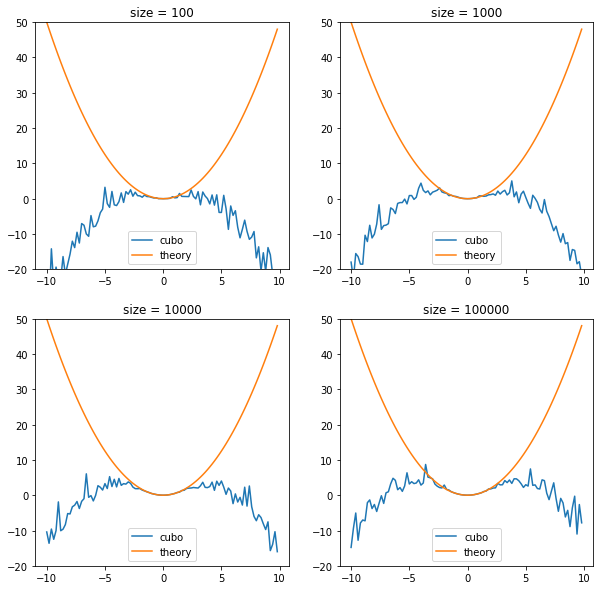

In [18]:
fig, ax = plt.subplots(2, 2, figsize = (10,10))
sample_sizes = [100, 1000, 10000, 100000]
log_p = lambda x, t: np.sum(sp.stats.norm.logpdf(x), axis=1) 
rs = npr.RandomState()

for i in range(4):
    mu1 = 0
    mu2s = np.arange(-10, 10, 0.2)
    elbos = []
    cubos = []
    for mu2 in mu2s:
        samples = rs.randn(sample_sizes[i], 1) + mu2 
        cubo_temp = get_cubo(np.array([mu2]), np.array([1]), log_p, family='normal', samples=samples)
        cubos.append(cubo_temp)
    theory = 0.5 * mu2s ** 2
    ax[i //2, i % 2].plot(mu2s, cubos, label = 'cubo')
    ax[i //2, i % 2].plot(mu2s, theory, label = 'theory')
    ax[i //2, i % 2].set_ylim(-20, 50)
    ax[i //2, i % 2].set_title('size = {}'.format(sample_sizes[i]))
    ax[i //2, i % 2].legend()

The above plot shows that when two distributions are far apart, the Monte Carlo estimate of CUBO can be extremely poor and degenerate. Increasing sample size alleviates the issue somewhat but as the distance increases, the sample size requirements increase exponentially. The problem is related to the concept of importance sampling. CUBO is defined as:

$$ \text{CUBO}_{2}(\hat \pi) = \log\left\{\int\left(\frac{d\pi'}{d\hat{\pi}}\right)^{2}d\hat{\pi}\right\}^{1/2} $$

We can view the quantity $\frac{d\pi'}{d\hat{\pi}}$ as importance weights. We evaluate these weights at samples from $\hat \pi$. There are four types of samples: (1) samples where both the proposal and target density are high; (2) samples where both are low; (3) samples where the proposal density is high and the target density is low; and (4) samples where the proposal density is low and the target density is high. When the distributions are far apart, type (3) is common and can lead to unstable weights which are excaerbated by raising the quantity to $\alpha$. Increasing the sample size results in better estimation as then we are more likely to get the other three types of samples. Additionally, using the $t$-family for VI as Huggins et al. recommend can also help this problem to some extent since for low degrees of freedom, the $t$ distribution is more robust at the tails.

We were not the first to notice this problem with CUBO. A recent paper by Pradier et al. (2019) performed experiments with CHIVI (where the variational objective is minimizing CUBO) and discovered this degeneracy issue when the proposal distribution is far away from the target. Notably, they show that this can lead to problems with CHIVI and it can be better to use a "warm" initializtion where one begins by performing KLVI to get distributions close together and then performing CHIVI. 

We also note that we are unsure how much this issue matters in practice. The use case for the proposed error bounds is with VI where one maximizes (or minimizes) the ELBO (or CUBO). Therefore, it may be the case that one usually results in $\hat \pi$ that is close enough to $\pi$ where CUBO estimates are reasonable. A useful strand of research may be to examine the performance of CUBO in various real-data settings.

One other area of future work may be in variance reduction techniques for estimates of CUBO. For example, control variates may be a useful way to generally reduce variance as we always know the form of the proposal distribution.

### 3.2.6 Effect of dimensionality

Next, we examine the effect of dimensionality on the tightness of the error bounds. So far we have only addressed the univariate case but in practice, these error bounds are used for VI which is frequently applied to very large datasets where the dimensionality can be extremely high (Blei et al. 2017). 

To experiment, we fix the true mean difference and vary the dimensionality such that the $L_2$-norm of the mean difference is always the same for each dimension. In the following examples, the dimension of target posterior distribution ranges from 1 to 100.

$$
\hat{\pi} \sim \text{N}(\frac{\textbf{1}}{\sqrt{d}},\text{I}_{d*d}) (d=\text{1,10,20,30,40,50,60,70,80,90,100})
$$

$$
\pi \sim \text{N}(\textbf{0},\text{I}_{d*d}) (d=\text{1,10,20,30,40,50,60,70,80,90,100})
$$

$$
\text{true mean difference} = 1
$$

Interestingly, the error bounds do tend to increase with the number of dimensions. To diagnose why this is the case, we also break out the components of the error bounds into the moment constant $C_p$ and the divergence bound $H_2$. We find that the divergence bound is similar across all dimensions but that the moment constant drives the error bound up. This is also clear from the analytical form:

$$ C^{PI}_{p}(\xi) = 2\inf_{\theta_0 \in \mathcal{X}}\left\{\int_{\mathcal{X}}||\theta - \theta_0||_2^p\xi(d\theta)\right\}^{1/p} $$

where the quantity $||\theta - \theta_0||_2^p$ increases as dimensions increase (if the mean difference is constant). This observation provides further guideline when interpreting results and provides an avenue for potential future research. In particular, this result gives guidance on what to consider a large error bound for any given dimensionality. Future work can formalize this more clearly. Additionally, this suggests the importance of examining the components of the error bounds separately and in many contexts it appears that the divergence bound may be the more useful quantity to examine.

We run the experiment with both lower dimensions $(1,2,...,10)$ and higher dimensions up to 500 and find similar results. Because of computational runtime we omit those results here. 

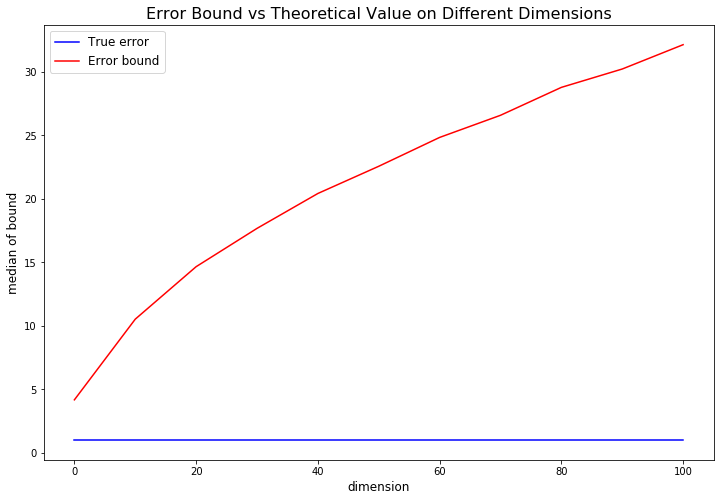

In [19]:
theoretical_value = []
result_value = []
Cp_stsh = []
H2_stsh = []
dim_range = range(0,110,10)
    
for i in dim_range:
    if i==0:
        i=1
    theoretical_value.append(1)
    result = []
    Cp_stsh_temp = []
    H2_stsh_temp = []
    log_density = lambda x: scipy.stats.multivariate_normal.logpdf(x, np.zeros(i), np.eye(i))
    for j in range(10):
        eb = Errorbound(mean=np.ones(i)/np.sqrt(i), std=np.ones(i), propose_family="normal", 
                        log_joint_posterior=log_density, num_samples=100000)
        dic = eb.get_bounds(verbose=False)
        result.append(dic['mean bound'])
        Cp_stsh_temp.append(eb.C_2p())
        H2_stsh_temp.append(eb.divergence_bound())
    result_value.append(np.median(result))
    Cp_stsh.append(np.median(Cp_stsh_temp))
    H2_stsh.append(np.median(H2_stsh_temp))
    
plt.figure(figsize=(12,8))
plt.plot(dim_range, theoretical_value, color='b', label='True error')
plt.plot(dim_range, result_value, color='r', label='Error bound')
plt.legend(fontsize=12)
plt.xlabel("dimension", fontsize=12)
plt.ylabel("median of bound", fontsize=12)
plt.title("Error Bound vs Theoretical Value on Different Dimensions", fontsize=16)
plt.show()

As we see from these plots, while the theoretical value of mean difference does not change, the error bound for the mean difference increases when dimension goes from 1 to 100. 

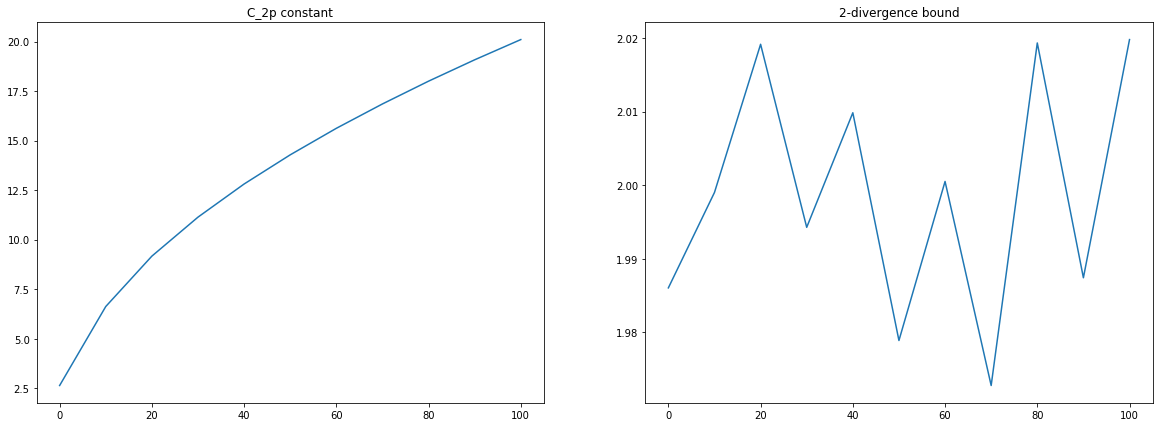

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))
ax[0].plot(dim_range, Cp_stsh)
ax[0].set_title('C_2p constant')
ax[1].plot(dim_range, H2_stsh)
ax[1].set_title('2-divergence bound')
plt.show()

We repeat the above experiment when the means are equal but the variances are different. Note that we take the square root of the variance bound in order to be on the same scale as the mean error.

$$
\hat{\pi} \sim \text{N}(\textbf{0},2 · \text{I}_{d*d}) (d=\text{1,10,20,30,40,50,60,70,80,90,100})
$$

$$
\pi \sim \text{N}(\textbf{0},\text{I}_{d*d}) (d=\text{1,10,20,30,40,50,60,70,80,90,100})
$$

$$
\text{true covariance difference} = 1
$$

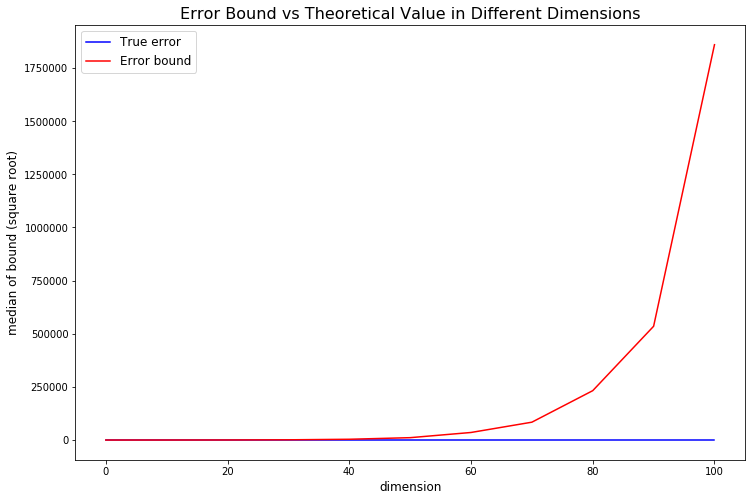

In [21]:
theoretical_value = []
result_value = []
Cp_stsh = []
H2_stsh = []
W2_stsh = []
dim_range = range(0,110,10)

for i in dim_range:
    if i==0:
        i=1
    theoretical_value.append(1)
    result = []
    Cp_stsh_temp = []
    H2_stsh_temp = []
    W2_stsh_temp = []
    log_density = lambda x: scipy.stats.multivariate_normal.logpdf(x, np.zeros(i), np.eye(i))
    for j in range(10):
        eb = Errorbound(mean=np.zeros(i), std=np.sqrt(2)*np.ones(i), propose_family="normal", 
                        log_joint_posterior=log_density, num_samples=100000)
        dic = eb.get_bounds(verbose=False)
        result.append(np.sqrt(dic['variance bound']))
        Cp_stsh_temp.append(eb.C_2p())
        H2_stsh_temp.append(eb.divergence_bound())
        W2_stsh_temp.append(eb.distance_bound())
    result_value.append(np.median(result))
    Cp_stsh.append(np.median(Cp_stsh_temp))
    H2_stsh.append(np.median(H2_stsh_temp))
    W2_stsh.append(np.median(W2_stsh_temp))
    
plt.figure(figsize=(12,8))
plt.plot(dim_range, theoretical_value, color='b', label='True error')
plt.plot(dim_range, result_value, color='r', label='Error bound')
plt.legend(fontsize=12)
plt.xlabel("dimension", fontsize=12)
plt.ylabel("median of bound (square root)", fontsize=12)
plt.title("Error Bound vs Theoretical Value in Different Dimensions", fontsize=16)
plt.show()

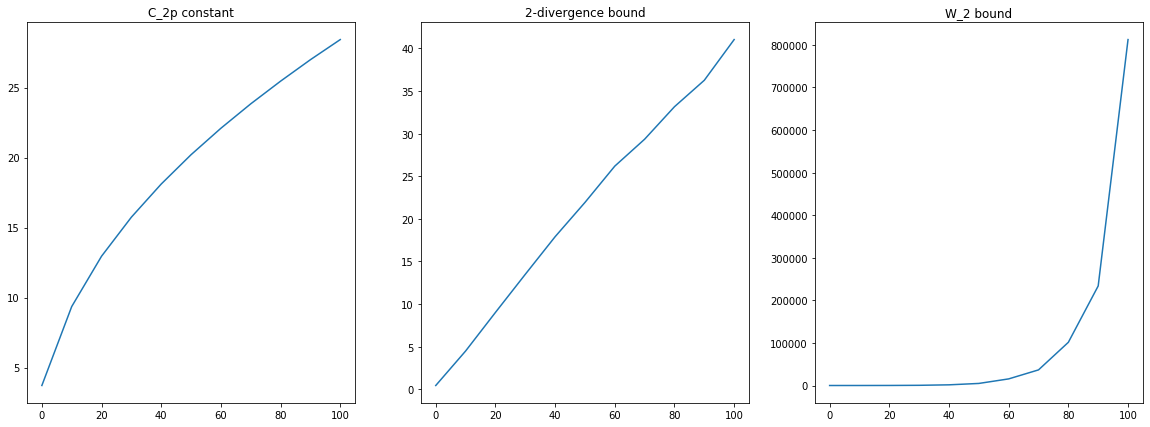

In [22]:
fig, ax = plt.subplots(1, 3, figsize = (20, 7))
ax[0].plot(dim_range, Cp_stsh)
ax[0].set_title('C_2p constant')
ax[1].plot(dim_range, H2_stsh)
ax[1].set_title('2-divergence bound')
ax[2].plot(dim_range, W2_stsh)
ax[2].set_title('W_2 bound')
plt.show()

The variance bound takes the form $3 \Sigma_{\hat \pi}\epsilon + 5.25\epsilon^2 $ where $\epsilon$ is the $W_2$ bound. Interestingly, both the moment constant and divergence bound increase as the dimensions increase, resulting in the eventual explosion of the error bound in high dimensions. We would likely need to scale the number of samples with the dimensions to regulate estimation of ELBO and CUBO to stabilize the divergence bound.

According to our experiments, the error bounds given by the algorithm proposed may be difficult to interpret in some high-dimensional problems. It is worth noting that though the theoretical value of the mean and variance errors do not change much across dimensions from 1 to 100, Wasserstein distance indeed goes up with increasing dimension. Since the algorithm tries to bound mean and variance error with Wasserstein distance, the error bound it gives is high in high-dimensional situations.

## 3.3 Conclusion for evaluation

In this section we have performed various simulation exercises to examine how the proposed error bounds perform in various settings. We identified several broad areas of future research including better estimation of CUBO and interpretation at higher dimensions. We also showed that the error bounds given by the algorithm can be misleadingly small even when the differences in distributions are far apart because of underestimation of CUBO in practice. However, Huggins et al. propose in their workflow to begin VI evaluation by using the $\hat k$ statistic which is related to the theory of importance sampling (Yao et al. 2018). The use of this statistic *before* calculating the error bounds may alleviate the problems with CUBO estimation (recalling that CUBO estimation is also related to the theory of importance sampling). 

Use of these error bounds (and the proposed workflow) in a variety of real-data settings would be helpful in evaluating the concerns we raised here. Lastly, we note that these proposed error bounds are flexible and can fit in with any workflow that involves evaluation of variational approximations. Thus, they are natural to combine with other methods and evaluation tools.

# 4. Reproduction of case study

## 4.1 Introduction of the eight schools example

Huggins et al. illustrate their algorithm on a classic meta-analysis of parallel experiments in eight schools, which is presented in Gelman et al. (2013, Sec. 5.5) and originally appeared in Rubin (1981). The study analyzed the effects of teaching programs on test scores in eight schools, with randomized experiments conducted in each school. The results of the study are estimated treatment effects $y$ and their standard errors $\sigma$ for each of the eight schools.

The data is reproduced below (Gelman et al., 2013, Sec. 5.5):

In [23]:
%%html
<img src="figures/ES.png" width="40%">

## 4.2 Hierarchical modeling

Rubin (1981) proposed the following hierarchical model to analyze the data:

$$
\begin{split}
\mu \sim N(0, 5^2) \\
\tau \sim \text{Half-Cauchy}(0,5^2) \\
\theta_n \sim N (\mu, \tau^2) \\
y_n \sim N(\theta_n, \sigma_n^2)
\end{split}
$$

where $n \in \{1,\dots,8\}$ and the $\{y_n, \sigma_n\}$ are given as data. The use of a hierarchical model allows for partial pooling across schools and results in better estimates than if schools are completely pooled together or not pooled at all. This is a classic Baysian problem because the posterior distribution does not have a simple closed form and MCMC or variational inference are required.

Huggins et al. implement this model (centered) as well as a version where $\theta$ is non-centered. Here we present the implementation of only the centered model. 

## 4.3 Implementation using HMC and KLVI

Huggins et al. fit this model using Hamiltonian Monte Carlo which serves as ground truth. They approximate the model using KLVI and CHIVI with $t$ families with 40 degrees of freedom. After examining the results, they then fit a non-centered parameterization of the model again with KLVI and CHIVI, but this time with both 40 and 10 degrees of freedom. 

For simplicity, we fit only HMC and KLVI for the centered parameterization (using the $t$ family with 40 degrees of freedom). We do not achieve the exact same results as those in the paper for KLVI, possibly because of different initializations and stochastic learning rates. Nevertheless, our results are similar and we note that the actual BBVI algorithm is not important in this case since we are more generally interested in using the proposed error bounds to compare two distributions. 

### 4.3.1 Hamiltonian Monte Carlo of Eight Schools (ground truth)

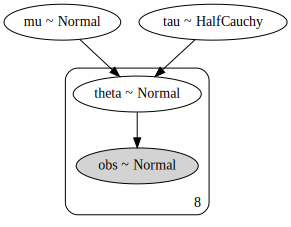

In [24]:
from pymc3 import model_to_graphviz
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigmas = np.array([15, 10, 16, 11, 9, 11, 10, 18])
N = 8
with pm.Model() as centered_eight:
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sd=tau, shape=N)
    obs = pm.Normal('obs', mu=theta, sd=sigmas, observed=y)
model_to_graphviz(centered_eight)

In [25]:
SEED = 41968154
with centered_eight:
    c_trace = pm.sample(10000, tune=2500, target_accept=0.95, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau, mu]
Sampling 2 chains: 100%|██████████| 25000/25000 [01:26<00:00, 288.40draws/s]
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 187 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9011432154659238, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


### 4.3.2 KLVI

In order to use BBVI, we need to define the joint distribution $\pi'$. We have the data $y = (y_1, y_2, \dots, y_8) = (28, 8, -3, 7, -1, 1, 18, 12),$ and a hierarchical model:

$$
\begin{split}
&p_{y|\theta}(y) = \prod\limits_{i=1}^8\frac{1}{\sqrt{2\pi\sigma^2_i}}exp\left(\frac{-(y_i - \theta_i)^2}{2\sigma^2_i}\right) = \prod\limits_{i=1}^8 \mathcal{N}(y_i; \theta_i, \sigma_i) \\
&p_{\theta|\mu, \tau}(\theta) = \prod\limits_{i=1}^8\frac{1}{\sqrt{2\pi\tau^2}}exp\left(\frac{-(\theta_i - \mu)^2}{2\tau^2}\right) = \prod\limits_{i=1}^8 \mathcal{N}(\theta_i; \mu, \tau)  \\
&p_{\mu}(\mu) = \frac{1}{5\sqrt{2\pi}}exp\left(\frac{-\mu^2}{50}\right) = \mathcal{N}(\mu; 0, 5) \\
&p_{\tau}(\tau) = \frac{1}{\pi}\left[\frac{10}{\tau^2 + 25}\right]\cdot\mathbb{1}_{\tau \geq 0} = \text{half-Cauchy}(\tau; 0, 5)
\end{split}
$$

where $\theta = (\theta_1, \theta_2, \dots, \theta_8),$ $(\sigma^2_1, \sigma^2_2, \dots, \sigma^2_8) = (15,10, 16, 11, 9, 11, 10, 18),$ and $\mathbb{1}_{\tau \geq 0} = \begin{cases}1 & \text{if} \; \tau \geq 0 \\ 0 & \text{else} \end{cases}.$ The posterior $\pi(\theta, \mu, \tau | y)$ is proportional to the joint:

$$
\pi^\prime(y, \theta, \mu, \tau) = p_{y|\theta}(y)\cdot p_{\theta|\mu, \tau}(\theta) \cdot p_{\mu}(\mu) \cdot p_{\tau}(\tau)
$$

In [26]:
def log_joint(W):
    
    # number of samples for each parameter
    S = W.shape[0]
    
    # unpack parameters
    mu = W[:, 0]
    tau = W[:, 1]
    thetas = W[:, 2:]
    
    # write priors
    log_mu_dist = -(1/2)*np.log(2*np.pi) - 1*np.log(sigma_mu) - (1/(2*sigma_mu**2))*(mu**2)
    log_tau_dist = np.log(2) - (np.log(np.pi) + np.log(sigma_tau) + np.log(1 + (tau/sigma_tau)**2))
    
    # log(thetas | mu, tau) and log(y | thetas, mu, tau)
    # for each sample, s, we compute 
    log_y_dist = []
    log_thetas_dist = []
    Sigma_y = (sigmas**2)*np.eye(N)
    Sigma_y_det = np.linalg.det(Sigma_y)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    
    for s in range(S):
        Sigma_theta = (tau[s]**2)*np.eye(N)
        Sigma_theta_inv = np.linalg.inv(Sigma_theta)
        Sigma_theta_det = np.linalg.det(Sigma_theta)
        
        log_y_dist.append(-0.5*(np.log(Sigma_y_det) + np.dot(np.dot((y - thetas[s]).T, Sigma_y_inv), y - thetas[s]) + N*np.log(2*np.pi)))
        log_thetas_dist.append(-0.5*(np.log(Sigma_theta_det) + np.dot(np.dot((thetas[s] - mu[s]).T, Sigma_theta_inv), thetas[s] - mu[s]) + N*np.log(2*np.pi)))
        
    log_y_dist = np.array(log_y_dist)
    log_thetas_dist = np.array(log_thetas_dist)
    
    return log_y_dist + log_thetas_dist + log_mu_dist + log_tau_dist
    
eight_log_density = lambda w, t: log_joint(w)

We use the BBVI implementation given by `autograd` and reproduced in class. We follow Huggins et al. and use the **t distribution** family with 40 degrees of freedom (although are code also allows for the normal family). We include an implementation of CHIVI but have had difficulty with stability and convergence. 

In [27]:
def black_box_variational_inference(logprob, D, num_samples, obj, family, df):
    
    """
    Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557
    code taken from:
    https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py
    """
    def t_entropy(df, scale=None):
        '''
        Taken from https://math.stackexchange.com/questions/2272184/differential-entropy-of-the-multivariate-student-t-distribution
        '''
        standard_entropy = ((df+1)/2)*(sp.special.digamma((df+1)/2) - sp.special.digamma(df/2)) + np.log(np.sqrt(df) * sp.special.beta(df/2, 1/2))
        if scale is None:
            return standard_entropy
        D = len(scale)
        return standard_entropy*D + np.log(scale).sum()

    def gaussian_entropy(log_std):
        D = len(log_std)
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian or independent t-distributions
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        
        if obj=='KL':
            if family=='normal':
                samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
                lower_bound = np.mean(logprob(samples, t)) + gaussian_entropy(log_std)
            elif family=='t':
                assert df is not None
                samples = rs.standard_t(df=df, size=(num_samples, D)) * np.exp(log_std) + mean
                lower_bound = np.mean(logprob(samples, t)) + t_entropy(df=df, scale=np.exp(log_std))
            return -lower_bound
                
        if obj=='CHI':
            warn('this CHIVI implementation is not recommended')
            if family=='normal':
                samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
                log_weights = logprob(samples, t) - sp.stats.multivariate_normal.logpdf(samples, mean, np.diag(np.exp(log_std)**2))
                upper_bound = np.mean(np.exp(log_weights)**2)
            if family=='t':
                assert df is not None
                samples = rs.standard_t(df=df, size=(num_samples, D)) * np.exp(log_std) + mean
                log_weights = logprob(samples, t) - np.sum(sp.stats.t.logpdf(samples, mean, np.exp(log_std)), axis=1)
                upper_bound = np.mean(np.exp(log_weights)**2)
            return upper_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

def variational_inference(log_density, init_mean, init_sd, D, S, max_iteration, step_size, family='normal', obj='KL', df=None, verbose=True):
    '''
    log_density: log of joint target distribution
    init_mean: 
    '''
    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S, obj=obj, family=family, df=df)

    def callback(params, t, g):
        if verbose:
            if  t % 100 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    
    #initialize variational parameters
    init_log_std = np.log(init_sd)
    init_var_params = np.concatenate([init_mean, init_log_std])
    
    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    return variational_params 

In [28]:
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigmas = np.array([15, 10, 16, 11, 9, 11, 10, 18])
D = 10
N = 8
sigma_tau = 5
sigma_mu = 5
df = 40
mu_tau_init = np.array([6, np.log(np.std(y))])
init_means = np.append(mu_tau_init, [5,5,5,5,5,5,5,5])
init_log_std = np.array([1,-1,2,2,2,2,2,2,2,2])
init_sd = np.exp(init_log_std)

# run BBVI (using t-family with df=40)
variational_params_eight = variational_inference(eight_log_density, init_means, init_sd, D, S=500, max_iteration=300, step_size=1e-1, family='t', df=40, verbose=True)
# print results
eight_means = variational_params_eight[:D]
eight_sd = np.exp(variational_params_eight[D:])
print('means:', eight_means)
print('sd:', eight_sd)

Optimizing variational parameters...
Iteration 0 lower bound -75.79813531068756; gradient mag: 61.80713200594665
Iteration 100 lower bound -33.80941656422824; gradient mag: 0.8427044753363137
Iteration 200 lower bound -33.58886037976147; gradient mag: 0.43153366389018283
means: [4.43746424 4.37450923 6.01564596 4.95878649 3.91519736 4.80980007
 3.54750025 3.95023218 6.42254111 4.66674651]
sd: [1.34985417 0.80539892 3.84497623 3.63577122 3.9184809  3.73429725
 3.61861915 3.73594084 3.61566246 3.86553614]


### 4.3.3 Comparision between HMC and KLVI

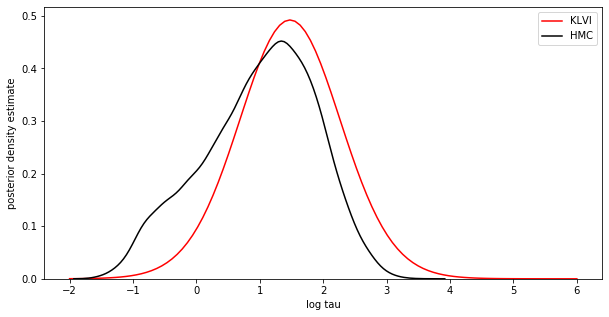

In [29]:
# reproduce figure 1 in the paper
x_range = np.linspace(-2, 6, 100)

fig, ax = plt.subplots(1, 1, figsize = (10,5))
ax.plot(x_range, sp.stats.t.pdf(x_range, loc = np.log(eight_means[1]), scale = eight_sd[1], df = 40), color='red', label='KLVI')
ax.set_xlabel('log tau')
ax.set_ylabel('posterior density estimate')
sns.distplot(np.log(c_trace['tau']), hist=False, color='black', label='HMC')
plt.show()

We reproduce Figure 1 from the paper above. The version in Huggins et al. uses the non-centered model which we did not implement. However, our KLVI estimate is reasonably close and the HMC estimate appears correct.

Next, we examine the contour plots in Figure 2 of Huggins et al. which show the distributions of $\log(\tau)$, $\mu$ and $\theta_1$.

In [30]:
def plot_contour(trace, ax1, ax2, label = ""):
    theta_trace = trace['theta']
    theta0 = theta_trace[:, 0]
    logtau = np.log(trace['tau'])
    mu = trace['mu']
    
    sns.set_style("white")
    sns.kdeplot(logtau, theta0, ax = ax1, label = label)
    ax1.axis([-3, 4, -15, 30])
    ax1.legend()
    
    sns.kdeplot(logtau, mu, ax = ax2, label = label)
    ax2.axis([-3, 4, -5, 15])
    ax2.legend()

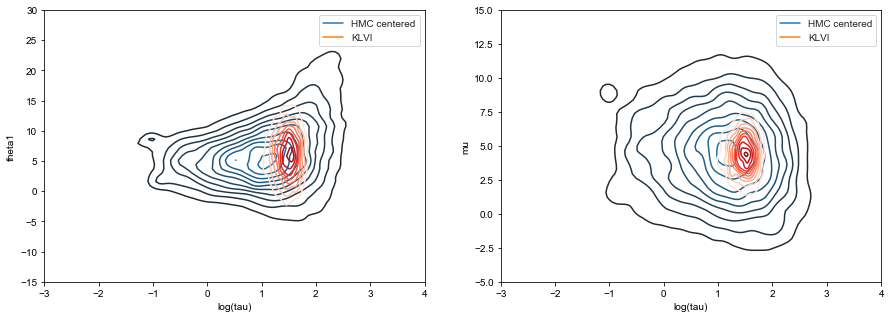

In [31]:
# reproduce figure 2(a) in the paper
rs = npr.RandomState()
W = rs.standard_t(df=40, size=(4000, len(eight_means))) * eight_sd + eight_means
logtau = np.log(W[:, 1])
mu = W[:,0]
theta1 = W[:, 2]

fig, axs = plt.subplots(1, 2, figsize = (15,5))
plot_contour(c_trace, axs[0], axs[1], "HMC centered")

sns.kdeplot(logtau, theta1, cmap="Reds", ax = axs[0], label = "KLVI")
sns.kdeplot(logtau, mu, cmap="Reds", ax = axs[1], label = "KLVI")
axs[0].legend()
axs[0].set_xlabel('log(tau)')
axs[0].set_ylabel('theta1')
axs[1].legend()
axs[1].set_xlabel('log(tau)')
axs[1].set_ylabel('mu')

plt.show()

In [32]:
%%html
<img src="figures/paperFig2.png" width="80%">

Figure 2 proposed in the paper (copied).

From the contour plot we notice that our result is quite similar to the one proposed in the paper. The only difference is that in the second figure the variance of $log(\tau)$ is not as wide as in the paper for KLVI. The HMC estimates, however, are close approximations. 

## 4.4 Calculation of the error bound and interpretation

In this section we compare our calculated bounds with Table 1 in the paper (copied below).

In [33]:
%%html
<img src="figures/paperTab1.png" width="80%">

In [34]:
eb = Errorbound(mean=eight_means, std=eight_sd, propose_family='t', t_dist_df = 40,  
                log_joint_posterior=log_joint, num_samples = 10000)
dic = eb.get_bounds(verbose=True)
print(dic)

cubo: -28.743092131958782
elbo: -33.60237867496701
div_bound: 9.718573086016448
C_2p: 23.3635251065331
W2_bound: 265.28488392112774
{'mean bound': 265.28488392112774, 'std bound': 512.4910414070297, 'variance bound': 371648.18941375474}


In [35]:
HMC_mean = [np.mean(c_trace['mu']), np.mean(c_trace['tau'])] + list(np.mean(c_trace['theta'], axis = 0))
print(np.linalg.norm((eight_means - HMC_mean), ord = 2))

0.6744374652175879


In [36]:
temp = np.stack((c_trace['mu'], c_trace['tau']), axis = 0)
HMC_cov = np.cov(np.vstack((temp, c_trace['theta'].T)))
KLVI_cov = np.diag(eight_sd ** 2)
print(np.sqrt(np.linalg.norm((HMC_cov - KLVI_cov), ord = 2)))

9.007843764155885


Comparing to the first column in Table 1 of the paper, we see that our calculated $W_2$ bound is smaller and the true mean error between KLVI and HMC estimates (0.67) is also lower. As noted above, the lower $W_2$ bound may have been possible because of poor CUBO approximation. But we note that the true mean error is also lower so our $W_2$ bound may be accurate.

However, interestingly, their results show that the $W_2$ bound is not monotonic with the mean error. Comparing columns 1 and 3 of Table 1, we observe that the re-parameterization greatly tightened the $W_2$ bound from 1600 to 110 while the true mean error increased from 0.91 to 1.5. The mean error with PSIS, however, is much lower. We believe this observation is important as it suggests an interesting connection between the error bounds and importance sampling.

This observation also aligns with the proposed workflow which integrates the use of these error bounds with re-parameterization and importance sampling. 

# 5. Future work

The work done by Huggins et al. represents exciting work in a developing field. As Blei et al. (2017) note, variational inference has proved to be widely useful in the machine learning community but there are many open questions regarding the statistical and mathematical properties of VI. Given the novelty of these proposed error bounds, several possible extensions come to mind.

First, as Huggins et al. note, their proposed error bounds depend on the difference between the CUBO and ELBO when computing $H_2$. Estimation of CUBO is in respect to the variational approximation but ELBO is in respect to $\eta$ where $\eta$ is any distribution where $\pi \ll \eta$. We chose $\eta$ to be the approximation but it should be possible to optimize to select $\eta$ that minimizes $H_2$ and thus minimizes the Wasserstein bound. 

Second, in Section 3, we noted that the moment constant $C_p$ increases as the number of dimensions increases even if the mean error does not change. Further guidance on how to interpret the bounds for different dimensions may be helpful to researchers in practice.

Third, as we noted in Section 3, estimation of CUBO can be quite difficult. Improvements in this area by preventing, or detecting, the degeneracy we observed in CUBO estimation would be helpful in understanding when the computed bound is a useful estimator. Additionally, general ways to reduce the variance of CUBO Monte Carlo estimates (by e.g. control variates) would also be tremendously useful in producing stable bounds. 

Fourth, Huggins et al. note an interesting connection between $\alpha$-divergence and importance sampling. They cite Dieng et al. (2017) when mentioning that 2-divergence minimization is equivalent to the minimization of importance weight variance. Further research on the connection between these bounds and importance sampling (and PSIS) may yield better guidance within the proposed workflow or establish a new workflow. 

Finally, we reiterate that these error bounds have only been in the literature for about two months and therefore have not had the opportunity to be used extensively. We presented a few simple examples from simulated data and Huggins et al. presented one example using real data. Interesting practical questions still remain as there are further opportunities to explore with more complex simulated data and with other real-world applications. 

# Appendix

## A1. Divergence of Relative Entropy Between T-distribution and Standard Gaussian

If $\pi$ and $\hat{\pi}$ are two measures defined on the same measurable space and $\pi$ is absolutely continuous with respect to $\hat{\pi}$ (written $\pi \ll \hat{\pi}$), we define $$\text{KL}(\pi|\hat{\pi}) = \int\log\left(\frac{d\pi}{d\hat{\pi}}\right)d\pi $$ and $$D_{\alpha}(\pi|\hat{\pi})= \frac{1}{\alpha - 1}\log\int\left(\frac{d\pi}{d\hat{\pi}}\right)^{\alpha - 1}d\pi$$ where $\alpha \in (0, 1) \cup (1, \infty).$ 
	
Let $\lambda$ be the Lebesgue measure on $\mathbb{R}$ and let $\pi$ and $\hat{\pi}$ be  measures such that  $$\frac{d\pi}{d\lambda} = f_{\pi}(x; k) = \frac{\Gamma\left(\frac{k+1}{2}\right)}{\sqrt{k\pi}\Gamma\left(\frac{k}{2}\right)} \left(1+ \frac{x^2}{k}\right)^{- \frac{k+1}{2}},$$ and $$\frac{d\hat{\pi}}{d\lambda} = f_{\hat{\pi}}(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}.$$ That is, $\pi$ is the standard t-distribution with $k$ degrees of freedom and $\hat{\pi}$ is the standard Gaussian. Since $\pi \ll \hat{\pi}\ll \lambda$ and $\lambda \ll \hat{\pi},$ we have $$\frac{d\pi}{d\hat{\pi}} = \left[\frac{d\pi}{d\lambda}\right]\left[\frac{d\lambda}{d\hat{\pi}}\right] = \left[\frac{d\pi}{d\lambda}\right]\left[\frac{d\hat{\pi}}{d\lambda}\right]^{-1} = \frac{f_{\pi}(x; k)}{f_{\hat{\pi}}(x)}$$ and $$\int_{\mathbb{R}}g(x)d\pi = \int_{\mathbb{R}}g(x)f_{\pi}(x)d\lambda$$ for any $\pi$-integrable $g: \mathbb{R} \to \mathbb{R}.$ Therefore,
	\begin{align*}
		\text{KL}(\pi|\hat{\pi}) = \int_{\mathbb{R}}\log\left(\frac{d\pi}{d\hat{\pi}}\right)d\pi &= \int_{\mathbb{R}}\log\left(\frac{f_{\pi}(x; k)}{f_{\hat{\pi}}(x)}\right)f_{\pi}(x)d\lambda \\
		&= \mathbb{E}_{\pi}\left[\log(f_{\pi}(x; k))\right] + \int_{\mathbb{R}}\log\left(\sqrt{2\pi}e^{\frac{x^2}{2}}\right) f_{\pi}(x)d\lambda \\
		&= \mathbb{E}_{\pi}\left[\log(f_{\pi}(x; k))\right] + \int_{\mathbb{R}}\log\left(\sqrt{2\pi}\right) f_{\pi}(x)d\lambda + \int_{\mathbb{R}}\frac{x^2}{2}f_{\pi}(x; k)d\lambda \\
		&= \mathbb{E}_{\pi}\left[\log(f_{\pi}(x; k))\right] + \log\left(\sqrt{2\pi}\right) +  \frac{1}{2}\mathbb{E}_{\pi}\left[x^2\right].
	\end{align*} The term $\mathbb{E}_{\pi}\left[\log(f_{\pi}(x; k))\right]$ is the negative of the entropy of $\pi$ while $\mathbb{E}_{\pi}\left[x^2\right]$ is the variance. Wikipedia gives $$\mathbb{E}_{\pi}\left[\log(f_{\pi}(x; k))\right] = \frac{k + 1}{2}\left[\frac{\Gamma^\prime\left(\frac{k}{2}\right)}{\Gamma\left(\frac{k}{2}\right)}- \frac{\Gamma^\prime\left(\frac{k + 1}{2}\right)}{\Gamma\left(\frac{k + 1}{2}\right)}\right] - \log\left[\sqrt{k}\frac{\Gamma\left(\frac{k}{2}\right)\Gamma\left(\frac{1}{2}\right)}{\Gamma\left(\frac{k + 1}{2}\right)}\right],$$ and $$\frac{1}{2}\mathbb{E}_{\pi}\left[x^2\right] = \frac{k}{2(k - 2)}.$$ An inspection of the gamma function, say from wolframalpha, shows that $$\lim_{k\searrow 2}\mathbb{E}_{\pi}\left[\log(f_{\pi}(x; k))\right] < \infty.$$ Therefore, from the term $\frac{1}{2}\mathbb{E}_{\pi}\left[x^2\right],$ we must have $$\lim_{k\searrow 2}\text{KL}(\pi|\hat{\pi}) = \infty.$$ We note that if $D_{\alpha}(\pi|\hat{\pi}) < \infty,$ then Jensen's inequality would give 
	\begin{align*}
	D_{\alpha}(\pi|\hat{\pi}) &{}= \frac{1}{\alpha - 1}\log\int_{\mathbb{R}}\left(\frac{d\pi}{d\hat{\pi}}\right)^{\alpha - 1}d\pi \\
	&{}\geq \frac{1}{\alpha - 1}\int_{\mathbb{R}}\log\left(\frac{d\pi}{d\hat{\pi}}\right)^{\alpha - 1}d\pi & (\log \; \text{is concave}) \\
	&{}= \int_{\mathbb{R}}\log\left(\frac{d\pi}{d\hat{\pi}}\right)d\pi \\
	&{}= \text{KL}(\pi|\hat{\pi}).
	\end{align*} Now, since $\lim\limits_{k\searrow 2}\text{KL}(\pi|\hat{\pi}) = \infty,$ we must also have $$\lim_{k\searrow 2}D_{\alpha}(\pi|\hat{\pi}) = \infty.$$

# References

Bauckhage, Christian. 2014. "Computing the Kullback-Leibler Divergence between two Generalized Gamma Distributions." Arxiv. Available at https://arxiv.org/abs/1401.6853.

Blei, David M., Alp Kucukelbir, Jon D. McAuliffe. 2017. "Variational Inference: A Review for Statisticians." Journal of the American Statistical Association. DOI: 10.1080/01621459.2017.1285773. 

Dieng, Adji B., Dustin Tran, Rajesh Ranganath, John Paisley, David M. Blei. 2017. "Variational Inference via χ-Upper Bound Minimization." Arxiv. Available at https://arxiv.org/abs/1611.00328. 

Gelman, Andrew, John B. Carlin, Hal S. Stern, David B. Dunson, Aki Vehtari, Donald B. Rubin. 2013. *Bayesian Data Analysis* 3rd edition. New York: Chapman and Hall/CRC, https://doi.org/10.1201/b16018.

Gorham, Jackson, Lester Mackey. 2015. "Measuring Sample Quality with Stein's Method." Advances in Neural Information Processing Systems.

Gorham, Jackson, Lester Mackey. 2017. "Measuring Sample Quality with Kernels." International Conference on Machine Learning.

Gorham, Jackson, Andrew B. Duncan, Sebastian J. Vollmer, Lester Mackey. 2019. "Measuring sample quality with diffusions." The Annals of Applied Probability. 

Hoffman, Matthew D., David M. Blei, Chong Wang, John Paisley. 2013. "Stochastic variational inference." Journal of Machine Learning Research 14: 1303-1347.

Huggins, Jonathan H., Mikołaj Kasprzak, Trevor Campbell, Tamara Broderick. 2019. "Practical posterior error bounds from variational objectives." Arxiv. Available at https://arxiv.org/abs/1910.04102v2.

Kingma, Diedrik P. and Jimmy Lei Ba. 2015. "Adam: A method for stochastic optimization." In ICLR. Available at https://arxiv.org/pdf/1412.6980.pdf.

Kingma, Diederik P. and Max Welling. 2014. "Auto-Encoding Variational Bayes." Arxiv. Available at https://arxiv.org/abs/1312.6114.

Pradier, Melanie F., Michael C. Hughes, Finale Doshi-Velez. 2019. "Challenges in Computing and Optimizing Upper Bounds of Marginal Likelihood based on Chi-Square Divergences." Symposium on Advances in Approximate Bayesian Inference. Available at https://openreview.net/forum?id=BJxk51h4FS.

Rubin, Donald B. 1981. "Estimation in Parallel Randomized Experiments." Journal of Educational Statistics 6 (4):377-400.

Villani, Cedric. 2009. "Optimal transport: old and new." Grundlehren der mathematischen Wissenschaften. Vol. 338.

Wasserman, Larry. No date. "Optimal Transport and Wasserstein Distance." Available at http://www.stat.cmu.edu/~larry/=sml/Opt.pdf.

Yao, Yuling, Aki Vehtari, Daniel Simpson, Andrew Gelman. 2018. "Yes, but Did It Work?: Evaluating Variational Inference." Arxiv. Available at https://arxiv.org/abs/1802.02538.